In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
# b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt/ebai-estimates-trimmed")
b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt-relative_norm/ebai-estimates-trimmed")

In [3]:
print(b['enabled'])

ParameterSet: 13 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_gaia_g_norm@phoe...: True
   enabled@lc_gaia_rp_norm@pho...: True
   enabled@lc_gaia_bp_norm@pho...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [4]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
normGaiaDatasets = [d for d in b.datasets if 'norm' in d and 'gaia' in d]
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

rawDatasetPlotGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets]
normDatasetPlotGroups = [['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets]
allDatasetPlotGroups = rawDatasetPlotGroups + normDatasetPlotGroups

100%|██████████| 3673/3673 [08:45<00:00,  6.99it/s]
Fri, 05 Jan 2024 12:45 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Fri, 05 Jan 2024 12:45 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628678
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346


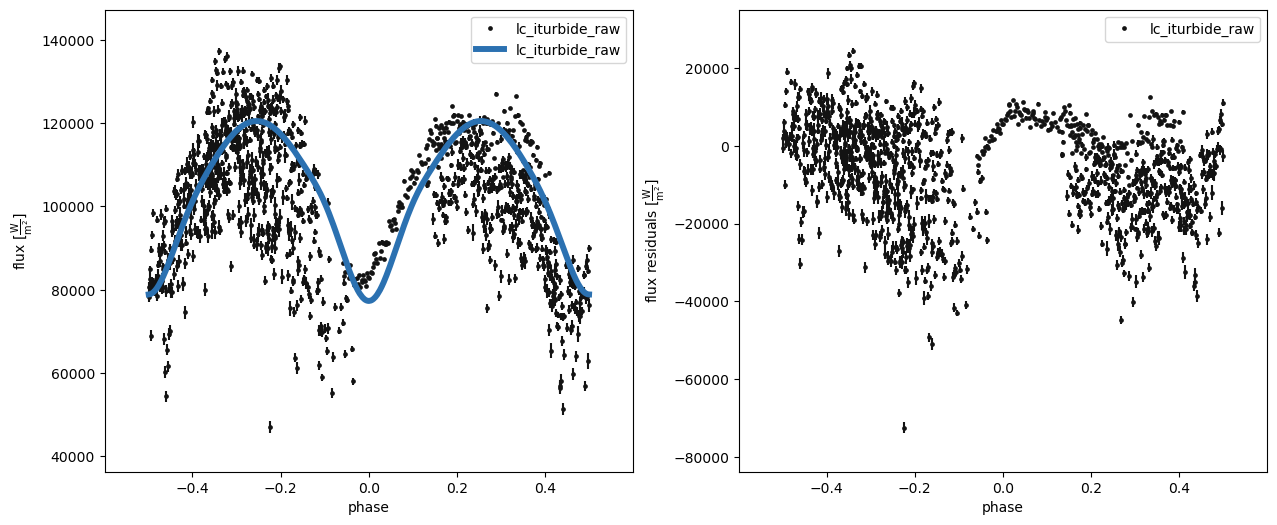

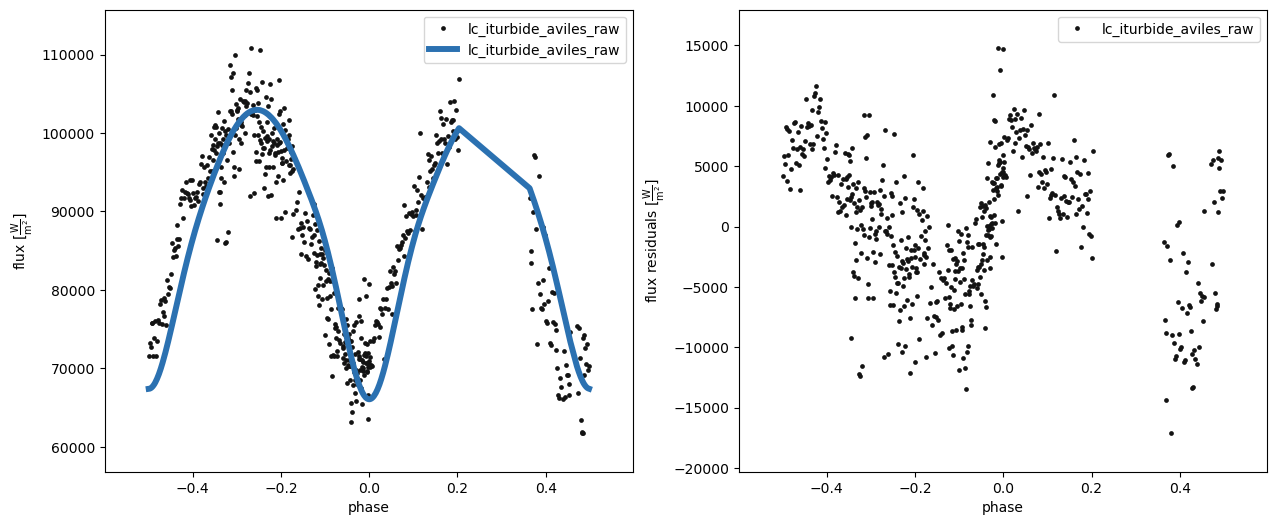

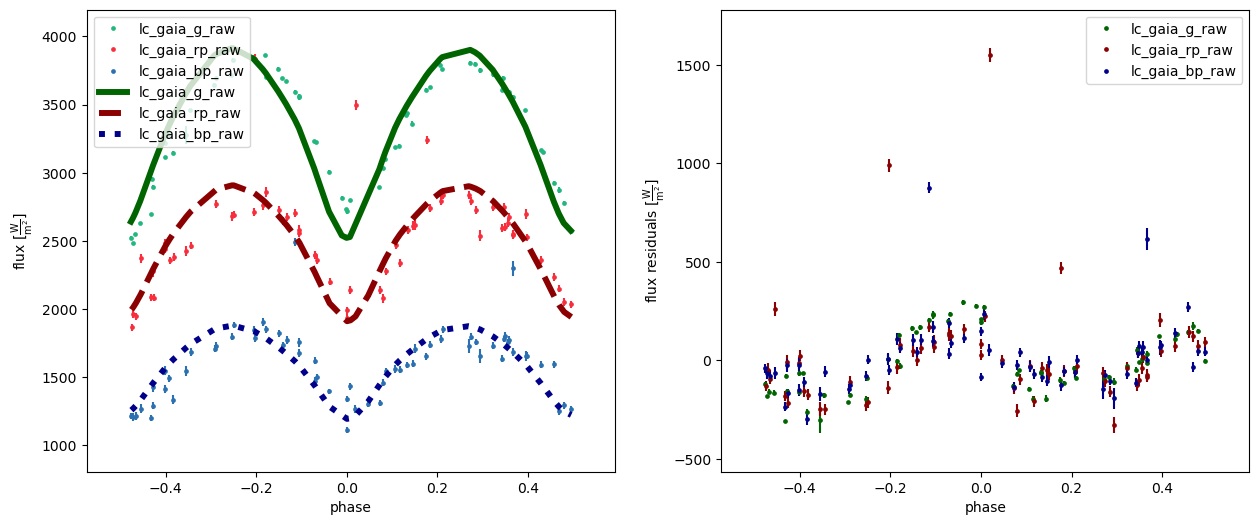

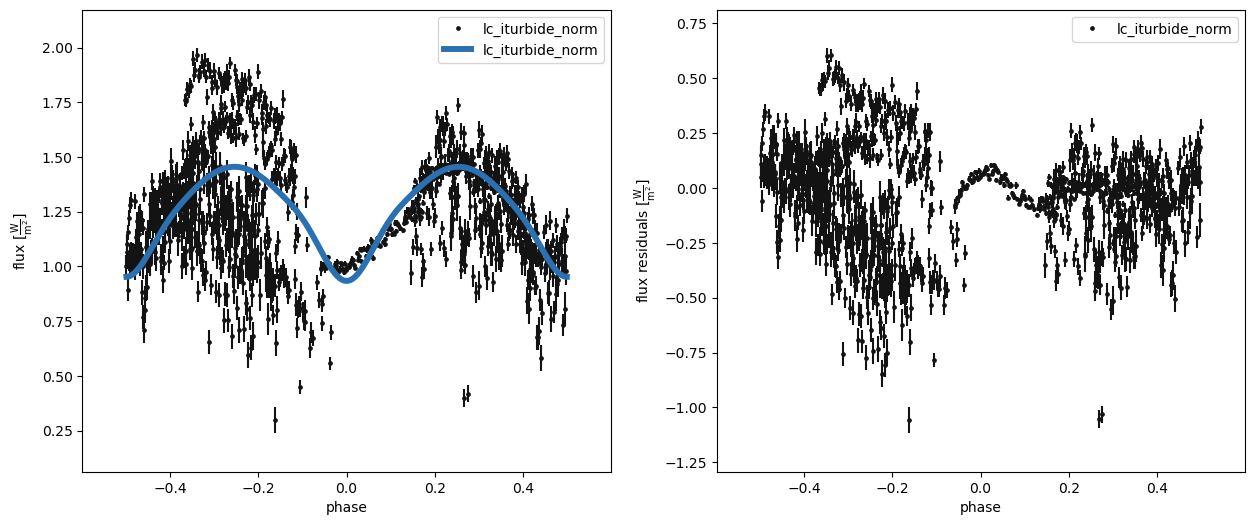

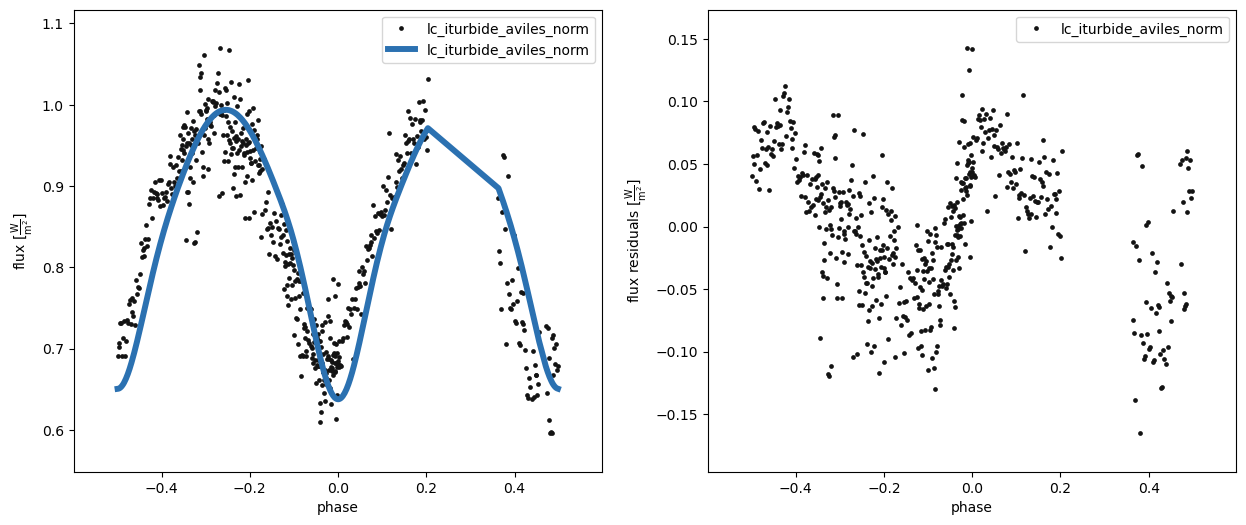

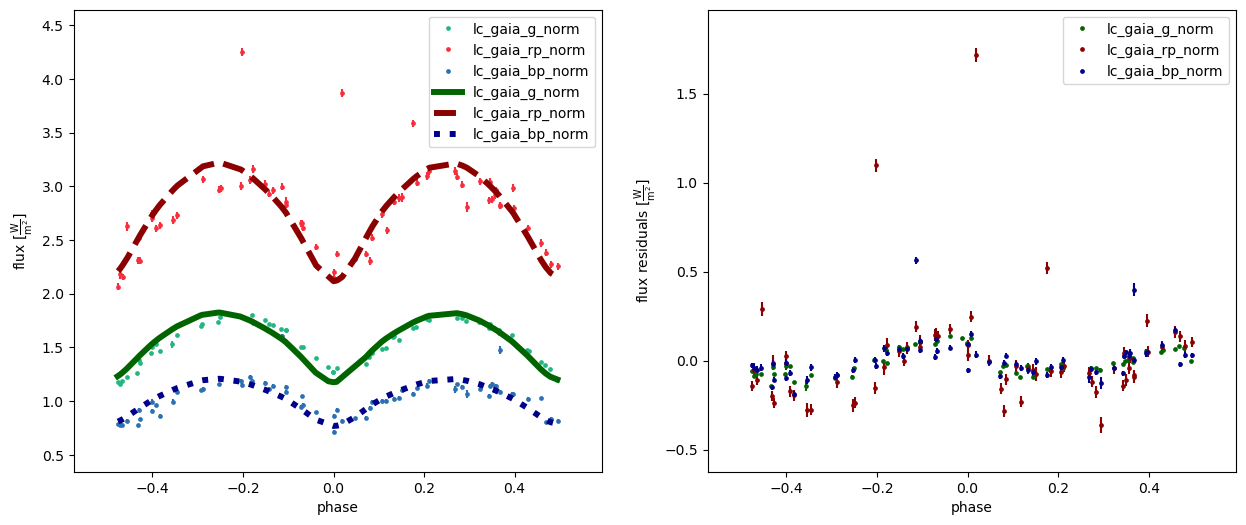

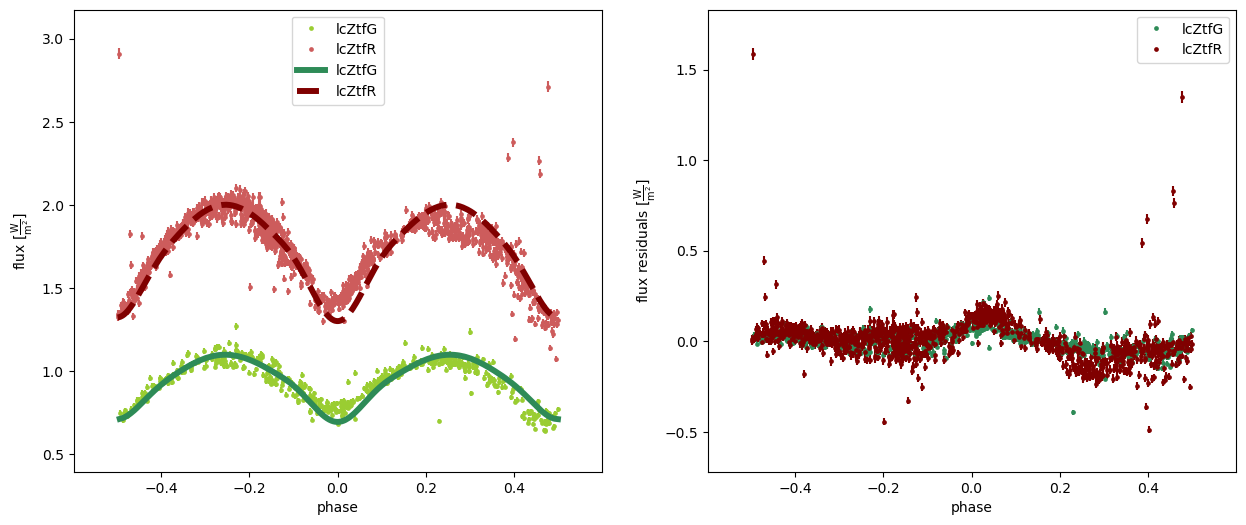

In [5]:
b.run_compute(model='before_optimizers', overwrite=True)
gen_utils.printChi2(b, 'before_optimizers')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=allDatasetPlotGroups, model='before_optimizers')

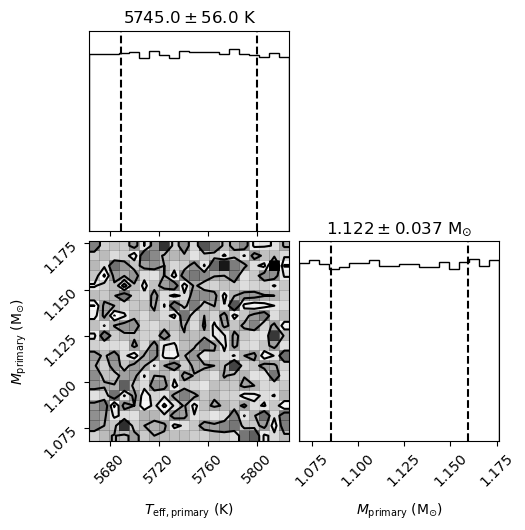

In [6]:
_ = b.plot_distribution_collection('poro_porb_bounds')

# Initial Parameters

In [7]:
print(b['q'])
print(b['mass'])
print(b['requiv'])
print(b['teff'])
print(b['teffratio'])
print(b['fillout_factor'])
print(b['incl@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.8564781150410867
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@bina

In [8]:
print(b['t0_supconj'])

Parameter: t0_supconj@binary@component
                       Qualifier: t0_supconj
                     Description: Zeropoint date at superior conjunction of the primary component
                           Value: -0.03747659625944774 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, compute_phases@mesh01@dataset, compute_phases@lc_iturbide_norm@dataset, compute_phases@lc_iturbide_raw@dataset, compute_phases@lc_iturbide_aviles_norm@dataset, compute_phases@lc_iturbide_aviles_raw@dataset, compute_phases@lc_gaia_g_norm@dataset, compute_phases@lc_gaia_rp_norm@dataset, compute_phases@lc_gaia_bp_norm@dataset, compute_phases@lc_gaia_g_raw@dataset, compute_phases@lc_gaia_rp_raw@dataset, compute_phases@lc_gaia_bp_raw@dataset, compute_phases@lcZtfG@dataset, compute_phases@lcZtfR@dataset
                      Related to: period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@b

# Period and `t0_supconj`

Eclipse timings look off from model to light curves, from slight positional offset.

In [9]:
opt_utils.optimize_params(b, fit_twigs=['period@binary', 't0_supconj'], label='per_t0', export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_per_t0.py


('opt_per_t0', 'opt_per_t0_solution')

Fri, 05 Jan 2024 12:45 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_per_t0_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
period@binary@orbit@component = 0.33357 d
t0_supconj@binary@orbit@component = -0.03754 d

Original values:
  period@binary@orbit@component 0.333566999 d
  t0_supconj@binary@orbit@component -0.03747659625944774 d


100%|██████████| 3673/3673 [08:43<00:00,  7.01it/s]
Fri, 05 Jan 2024 12:54 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Fri, 05 Jan 2024 12:54 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628678
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346
opt_per_t0_model
	 Iturbide (Aviles) (Raw) - 11589742432.340502
	 Iturbide (Full) (Raw) - 211488.21783108226
	 Gaia (Raw) - 10448.924385175385
		 lc_gaia_g_raw - 4912.824726698153
		 lc_gaia_rp_raw - 3853.7444540805986
		 lc_gaia_bp_raw - 1682.3552043966333
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.0798695213359042
	 Iturbid

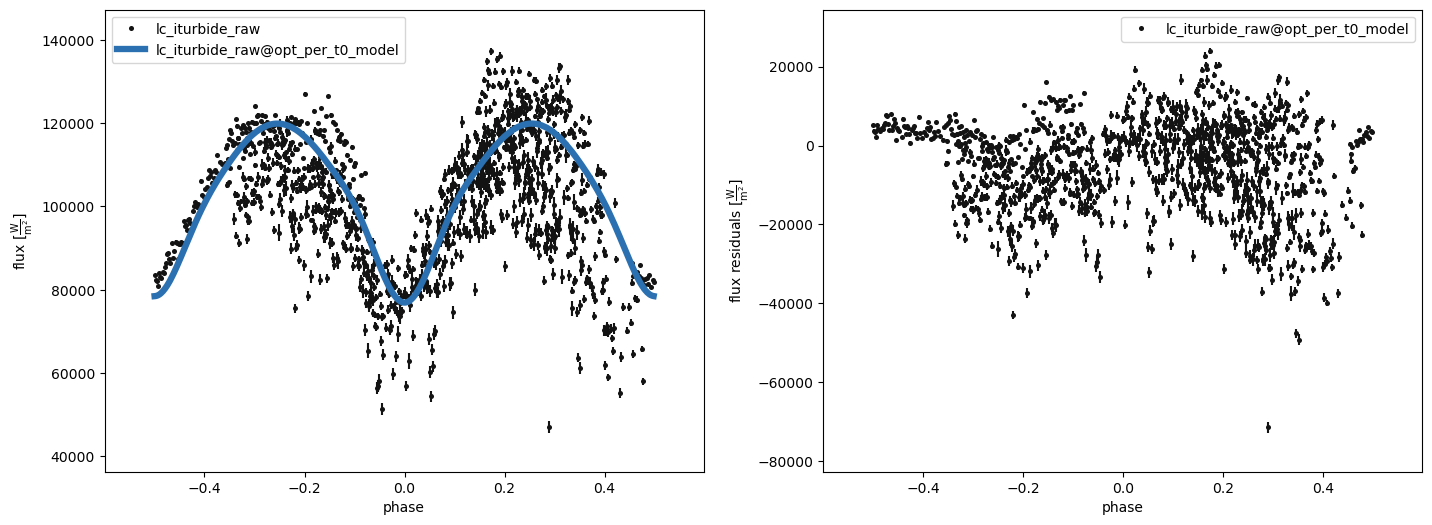

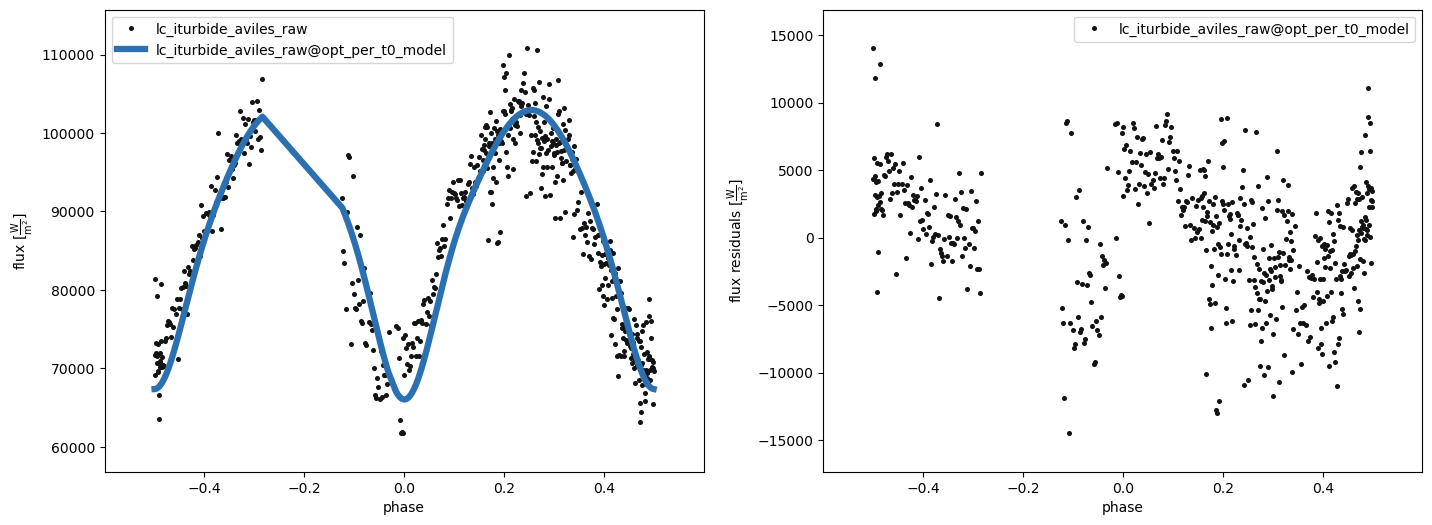

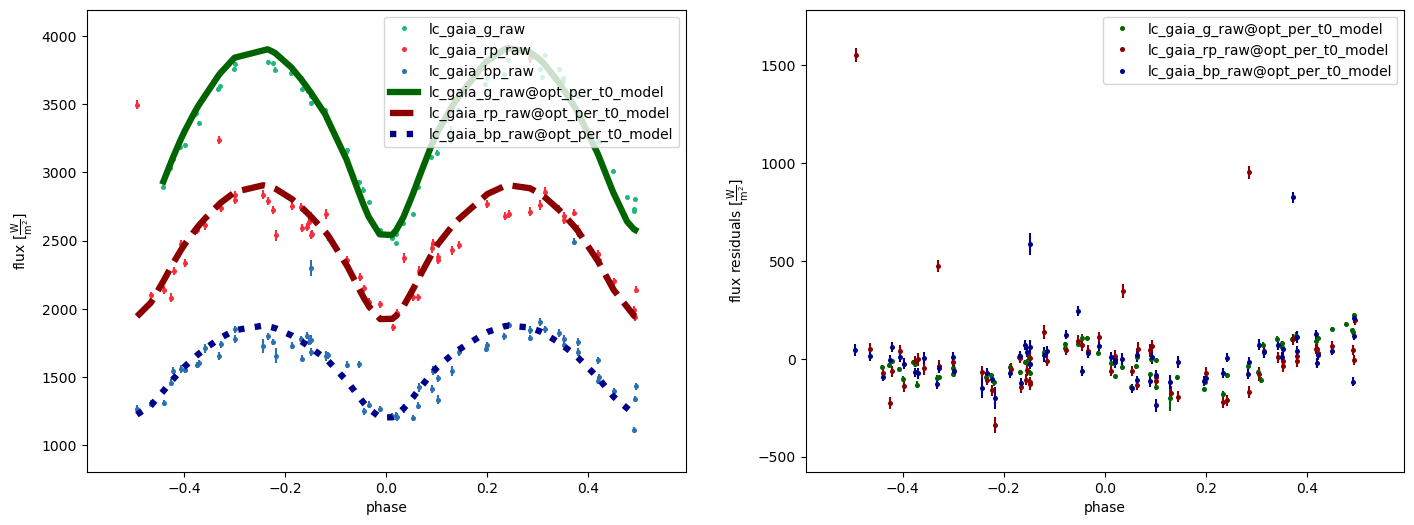

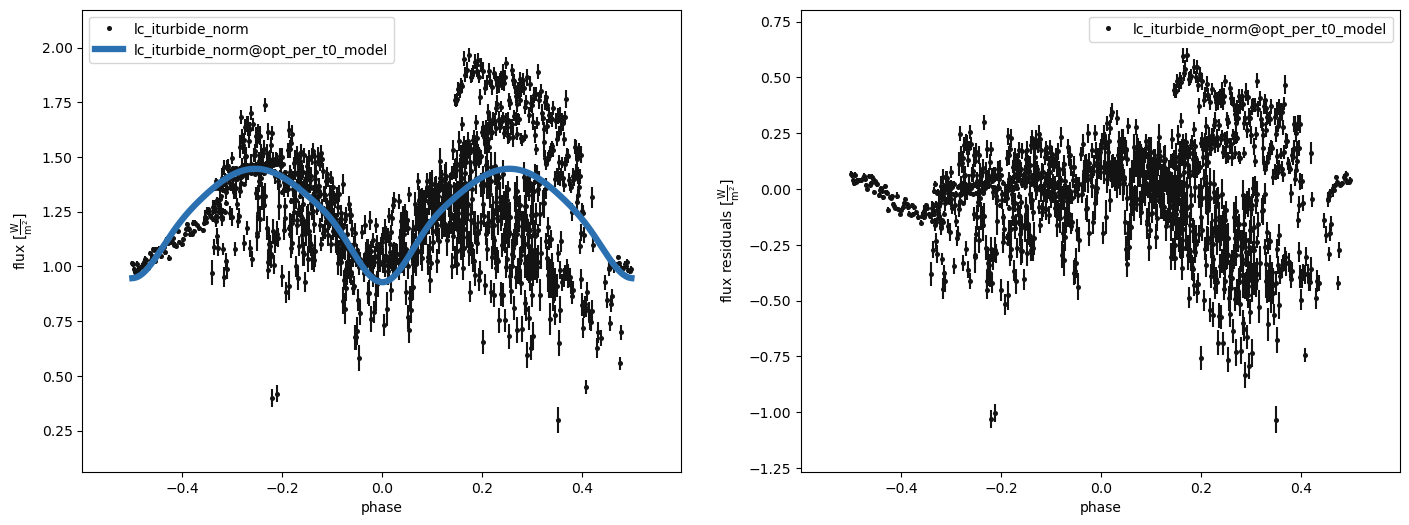

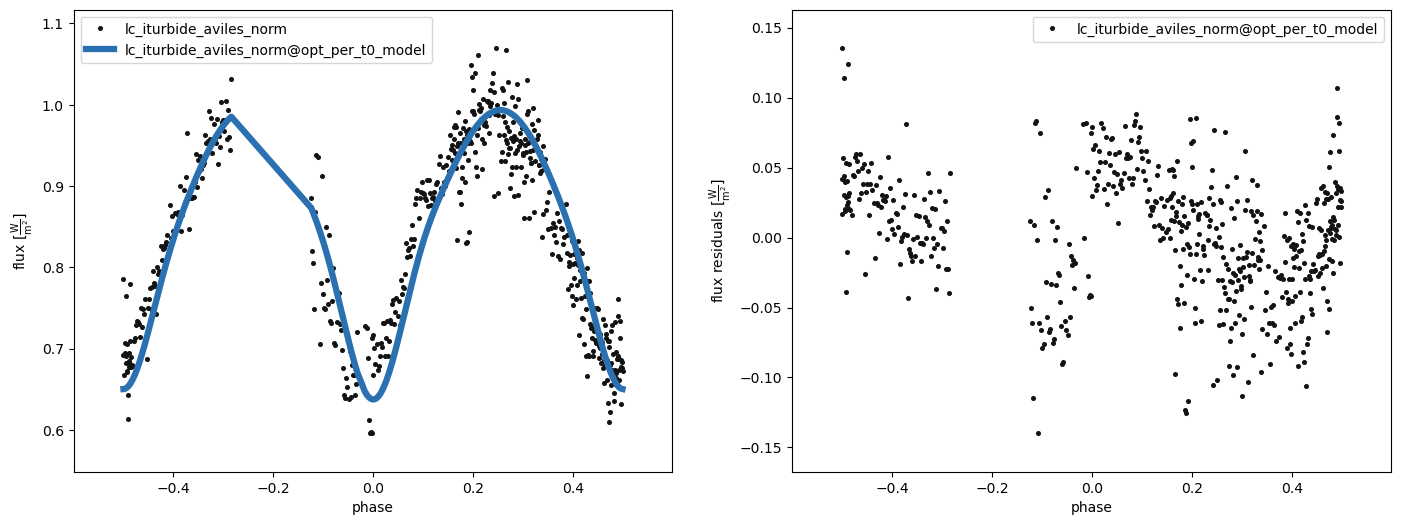

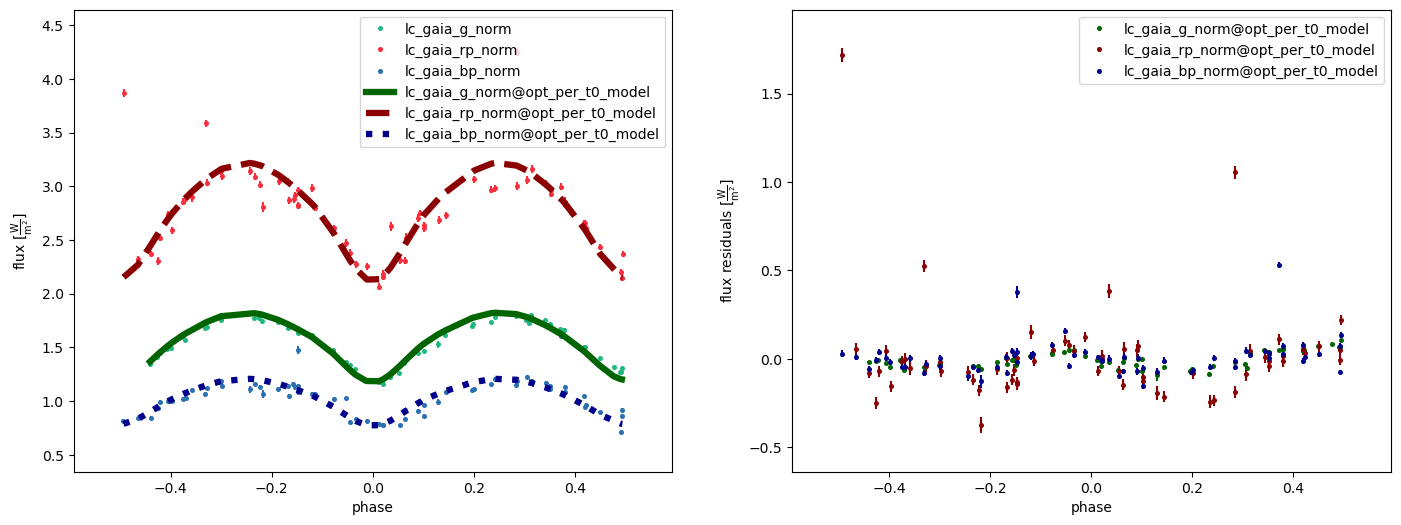

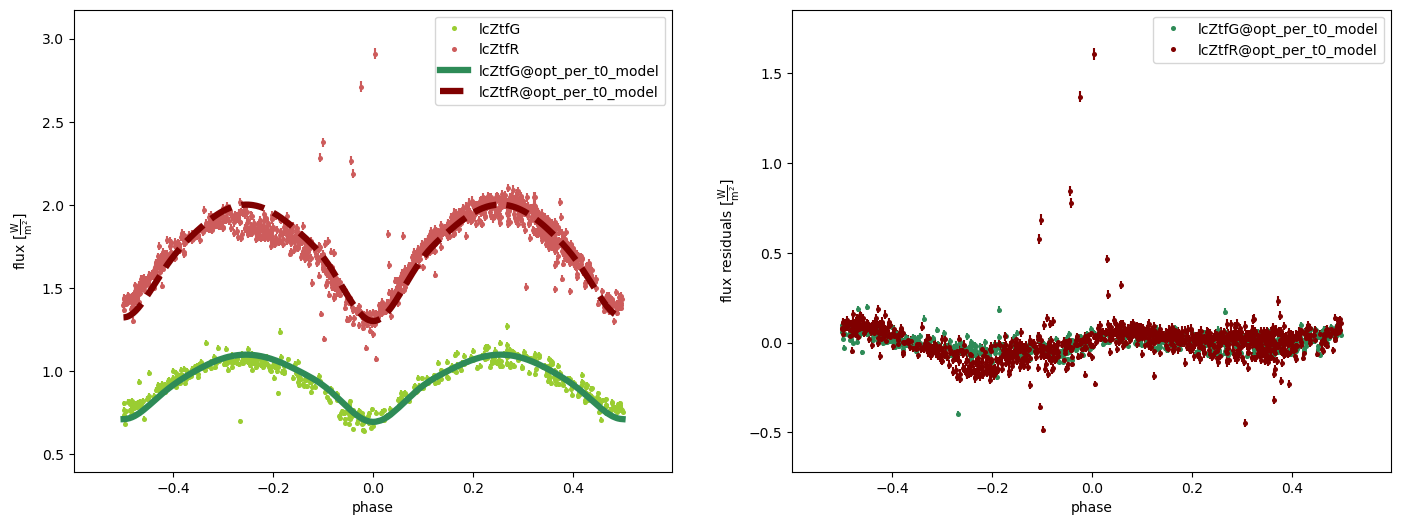

In [10]:
# using previous normalization solution; *should* be an applicable solution
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-ltt/results/opt_per_t0_solution", reset_params=False)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model=computeModelName)

# Eclipse Width and Depth

Adjusting $T_{eff}$ ratio (`teffratio`) based on eclipse depths, alongside the fillout factor (`fillout_factor`) to adjust the eclipse widths. Fillout factor
parametrization of component radii.

In [11]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff_vis", export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_teffr_ff_vis.py


('opt_teffr_ff_vis', 'opt_teffr_ff_vis_solution')

Adopted:
teffratio@binary@orbit@component = 0.96753 
fillout_factor@contact_envelope@envelope@component = 0.03527 

Original values:
  teffratio@binary@orbit@component 0.9857284692267768
  fillout_factor@contact_envelope@envelope@component 0.1852193760747716


100%|██████████| 3657/3657 [08:44<00:00,  6.97it/s]
Fri, 05 Jan 2024 13:03 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394764
		 lc_gaia_g_raw - 13229.176693503568
		 lc_gaia_rp_raw - 4308.280464088301
		 lc_gaia_bp_raw - 2220.4058763557705
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.6873189139604858
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503621
		 lc_gaia_rp_norm - 4308.2804640883
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628678
		 lcZtfG - 7510.758185009431
		 lcZtfR - 24668.343851277346
opt_per_t0_model
	 Iturbide (Aviles) (Raw) - 11589742432.340502
	 Iturbide (Full) (Raw) - 211488.21783108226
	 Gaia (Raw) - 10448.924385175385
		 lc_gaia_g_raw - 4912.824726698153
		 lc_gaia_rp_raw - 3853.7444540805986
		 lc_gaia_bp_raw - 1682.3552043966333
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.0798695213359042
	 Iturbid

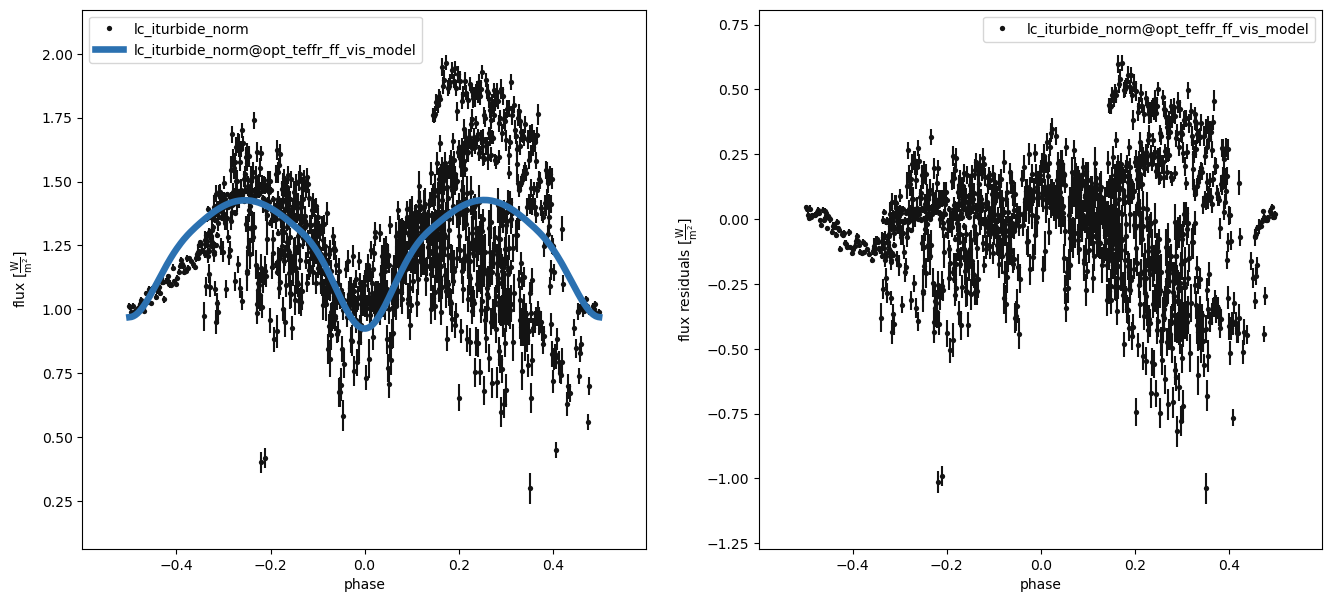

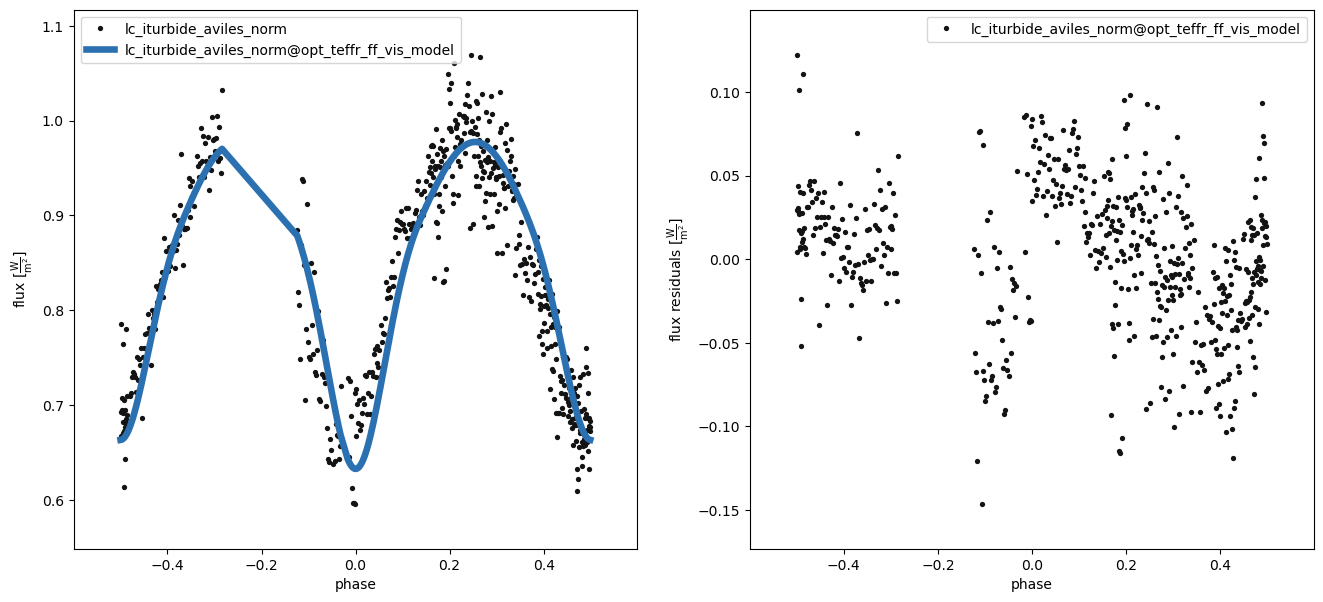

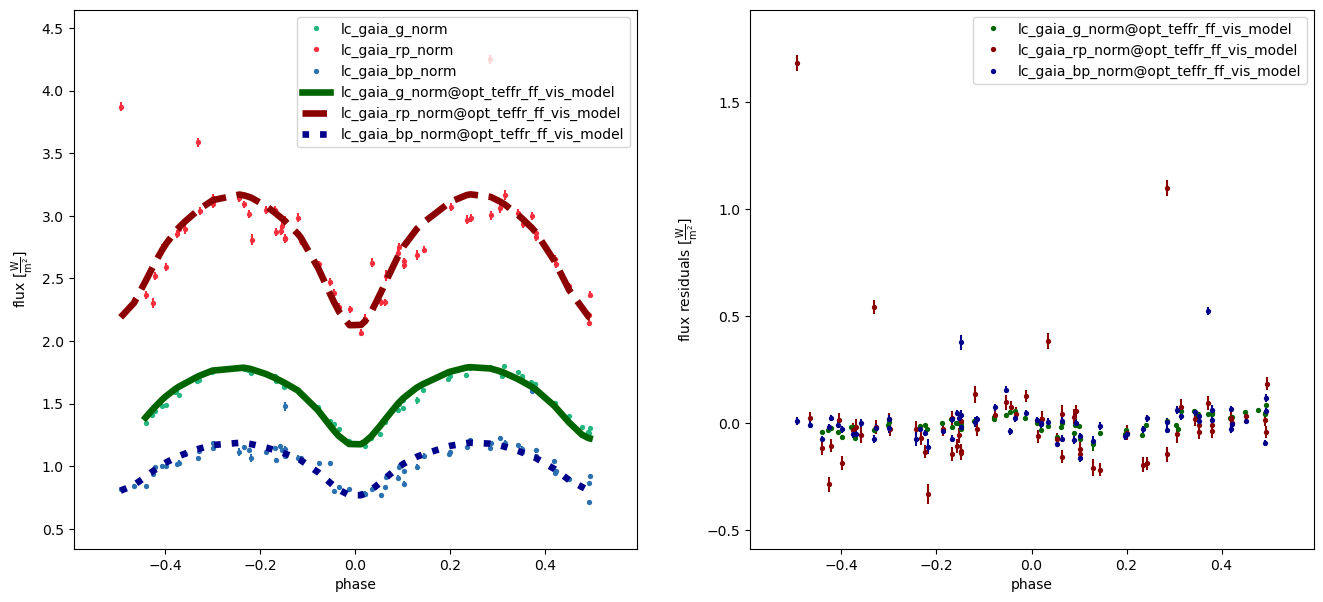

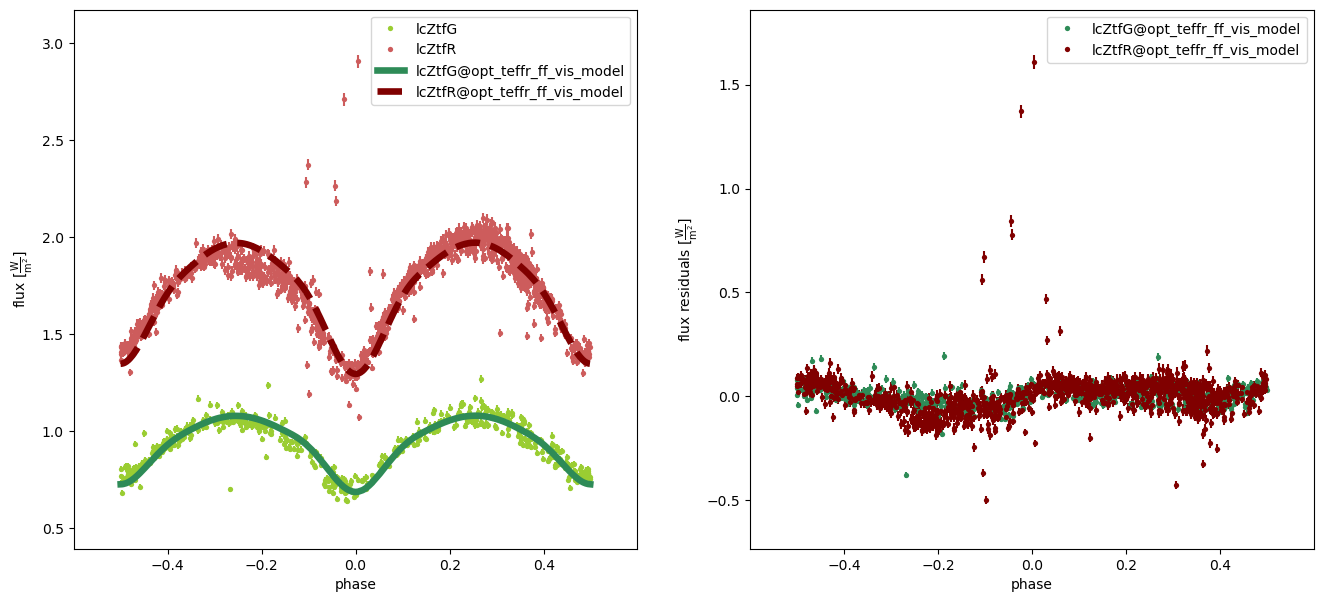

In [12]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teffr_ff_vis_solution", 
														  reset_params=True, dataset=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=normDatasetPlotGroups, model=computeModelName)

# Differential Evolution Adjustments (CONSISTENTLY GETS STUCK)

Final optimizations to approximate model to light curve before adjusting for temperatures. This will only act on parameters that affect relative shape of light curves, thus why it is done before adjusting for absolute temperatures and passband luminosity.

In [13]:
%%script echo "skipping; solver consistently gets stuck on 10th iteration every time"

b.add_distribution({
	'teffratio': phoebe.uniform_around(0.4),
	'incl@binary': phoebe.uniform_around(10),
	'fillout_factor': phoebe.uniform_around(0.1),
	'q': phoebe.uniform_around(0.4)
}, distribution='de_bounds', overwrite_all=True)

_ = b.plot_distribution_collection('de_bounds')

skipping; solver consistently gets stuck on 10th iteration every time


In [14]:
%%script echo "skipping; solver consistently gets stuck on 10th iteration every time"

opt_utils.optimize_params(b, fit_twigs=['teffratio', 'incl@binary', 'fillout_factor'], label='final_rel', datasets=ztfDatasets,
						  export=True, subfolder='iturbide-gaia-ztf-relative_norm',
						  optimizer='optimizer.differential_evolution', bounds=['de_bounds'], maxiter=50, popsize=16)

skipping; solver consistently gets stuck on 10th iteration every time


# Differential Correction Adjustments

Parameter optimization through differential corrections to get closer to parameter space minimum. Previous attempt with `differential_evolution` solver was unsuccessful due to a mysterious technical bug where the optimizer became stuck at 10 iterations consistently, regardless of optimizer configuration.

Opted for executing optimizer in notebook directly, since `differential_correction` is single-threaded and therefore benefits most from single core speed. Current servers have ancient CPUs, which, while having an enormous amount of threads to work with, are painfully slow for single-threaded tasks.

In [15]:
# original values

print(b['teffratio'])
print(b['incl@binary'])
print(b['fillout_factor'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.9857284692267768
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

Parameter: incl@binary@component
                       Qualifier: incl
                     Description: Orbital inclination angle
                           Value: 71.0744196944225 deg
                  Constrained by: 
                      Constrains: asini@binary@component, asini@primary@component, incl@primary@component, asini@secondary@component, incl@secondary@component
                      Related to: sma@binary@component, asini@binary@component, q@binary@component, asini@primary@component, pitch@primary@component, incl@primary@component, asini@secondary@component, pitch@secondary@

In [34]:
b.add_solver('optimizer.differential_corrections', solver='dc_relative', fit_parameters=['teffratio', 'incl@binary'], overwrite=True)

<ParameterSet: 9 parameters | qualifiers: expose_lnprobabilities, initial_values, fit_parameters, use_server, compute, steps, continue_from, comments, deriv_method>

In [46]:
from tqdm import tqdm

# progress bar generator
def generator():
    while True:
        yield

def gen_solution_path(solution: str) -> str:
    return os.path.join("external-jobs", "iturbide-gaia-ztf-relative_norm", "results", solution)

def run_dc_solver(b_dc: phoebe.Bundle, solver: str) -> None:
    PARAMS_FIT = len(b.get_value(qualifier='fit_parameters', solver=solver))
    THRESHOLD = np.ones(PARAMS_FIT) * 0.001

    solutionName = f"{solver}_solution"
    prevValues = np.ones(PARAMS_FIT) * np.inf

    for _ in tqdm(generator()):
        b_dc.run_solver(solver=solver, solution=solutionName, overwrite=True)
        curValues = np.asarray(b_dc.get_value(qualifier='fitted_values', solution=solutionName))
        gen_utils.printFittedVals(b_dc, solutionName)
        b_dc.adopt_solution(solutionName)

        print() # spacer
        
        ratio = curValues / prevValues
        curConvergence = np.abs(np.ones(PARAMS_FIT) - ratio)
        print(f"Convergence rate: {curConvergence}")
        print(f"Fit Chi2: {b_dc.get_value(qualifier='fitted_chi2', solution=solutionName)}")

        prevValues = curValues

        if (curConvergence <= THRESHOLD).all():
            b_dc.filter(context='solution', solution='dc_relative_solution', check_visible=False).save(gen_solution_path(solutionName), incl_uniqueid=True)
            break

Adopted:
teffratio@binary@orbit@component = 0.93386 
incl@binary@orbit@component = 66.54777 deg

Original values:
  teffratio@binary@orbit@component 0.9862546618378902
  incl@binary@orbit@component 66.54776777419643 deg


100%|██████████| 3673/3673 [08:47<00:00,  6.96it/s]


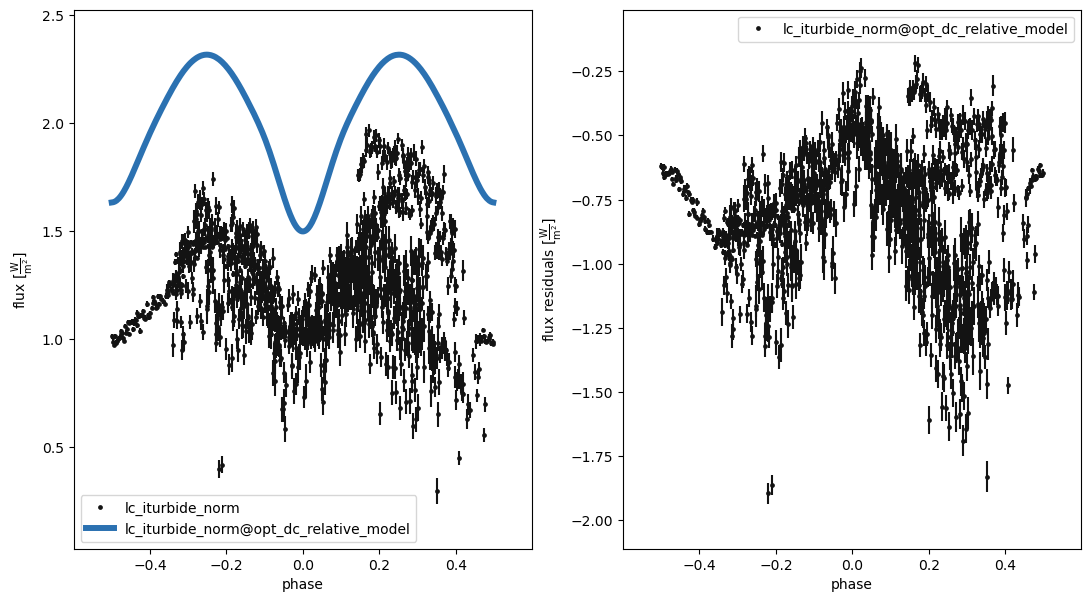

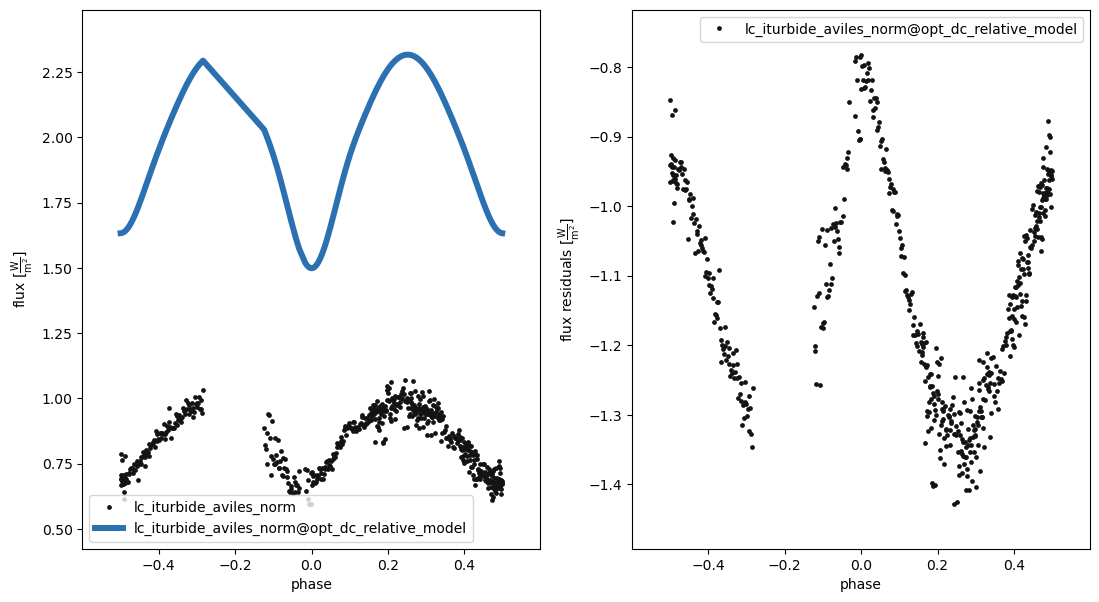

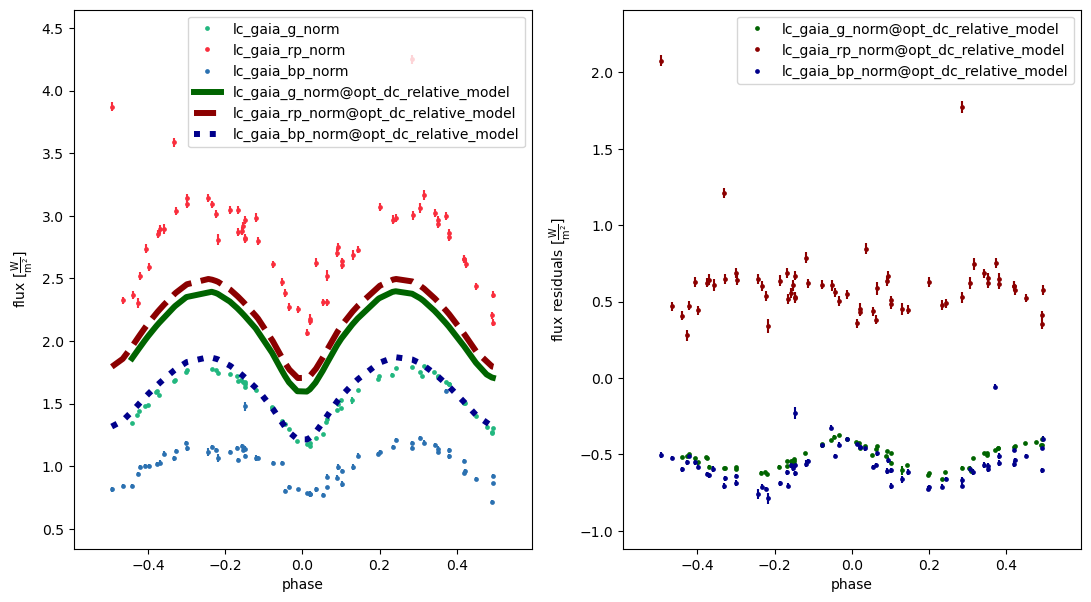

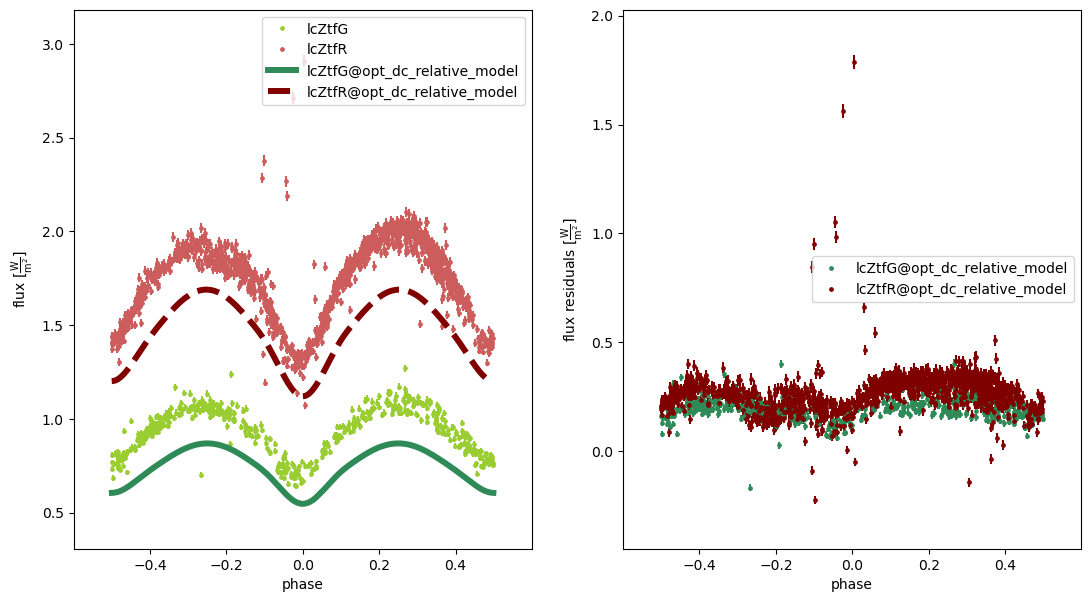

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [77]:
if not os.path.exists(gen_solution_path('dc_relative_solution')):
	dcBundle = b.copy()
	gen_utils.abilitateDatasets(dcBundle, ztfDatasets, False)
	run_dc_solver(dcBundle, 'dc_relative')

gen_utils.abilitateDatasets(b, ztfDatasets + normGaiaDatasets + ['lc_iturbide_norm', 'lc_iturbide_aviles_norm'])
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file=gen_solution_path('dc_relative_solution'), reset_params=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=normDatasetPlotGroups, model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

# Adjusting Component $T_{eff}$

Since these parameters are some of the last that will likely need to be adjusted for this model, here we try adjusting the component $T_{eff}$ using the color
difference from each set of light curves. The optimized temperatures will need to agree with Gaia and ZTF data, since this is where we have color information.

Will run 3 separate optimizers; one including normalized datasets only (+ZTF), one including raw datasets only (-ZTF), and one with raw datasets + ZTF normalized.

In [50]:
pb_backup = b.copy()

In [14]:
%%script echo "skip unless need to restore from backup"
b = pb_backup.copy()

skip unless need to restore from backup


In [51]:
b.set_value_all(qualifier='pblum_mode', 
				dataset=['lc_iturbide_raw', 'lc_iturbide_norm', 'lc_iturbide_aviles_raw', 'lc_iturbide_aviles_norm', 
			 			'lc_gaia_rp_raw', 'lc_gaia_rp_norm', 'lc_gaia_g_raw', 'lc_gaia_g_norm', 
						'lcZtfG'], 
				value='component-coupled')

# coupling Gaia BP and RP; Gaia G will be treated separately
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_raw', value='lc_gaia_rp_raw')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_norm', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_norm', value='lc_gaia_rp_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

In [16]:
%%script echo "skipping in favor of color coupling above"

# UNUSED FOR NOW; testing coupling different Gaia curves together instead above

b.set_value_all(qualifier='pblum_mode', 
				dataset=['lc_iturbide_raw', 'lc_iturbide_norm', 'lc_iturbide_aviles_raw', 'lc_iturbide_aviles_norm', 'lc_gaia_g_raw', 'lc_gaia_g_norm', 'lcZtfG'], 
				value='component-coupled')

# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='lc_gaia_g_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

UsageError: Line magic function `%%script` not found.


100%|██████████| 3673/3673 [09:07<00:00,  6.71it/s]


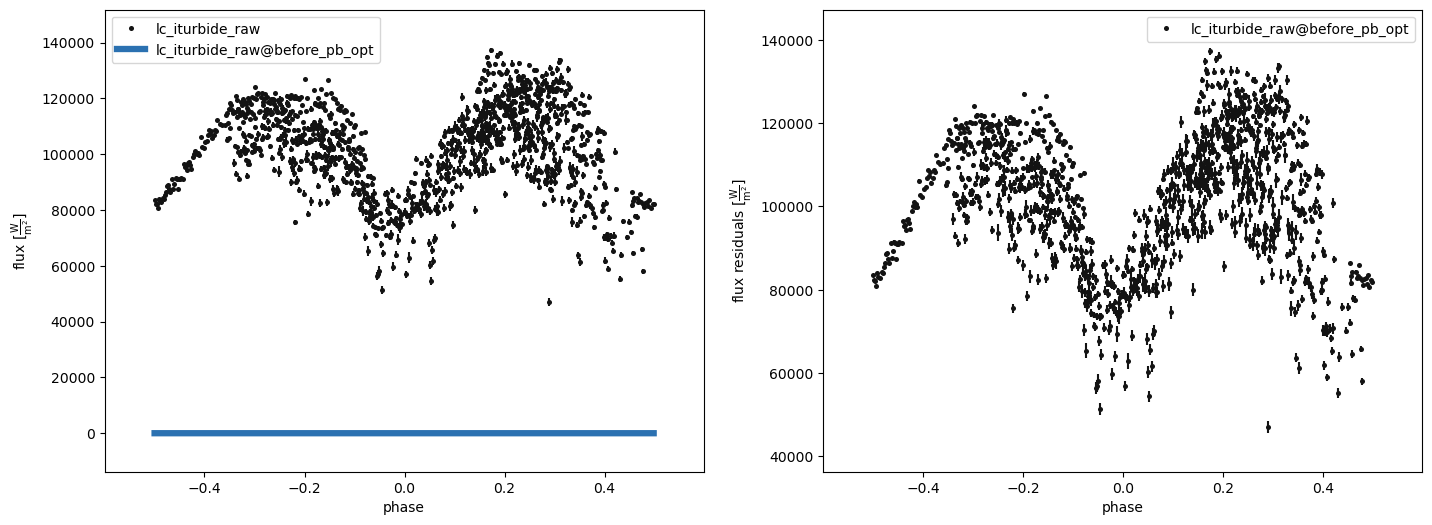

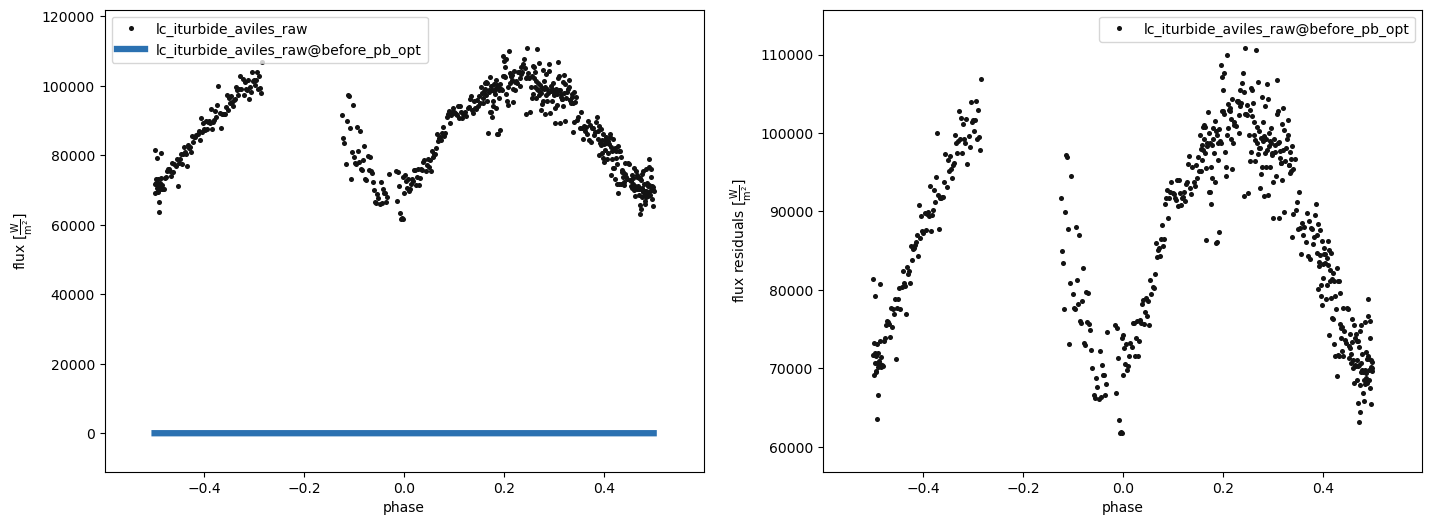

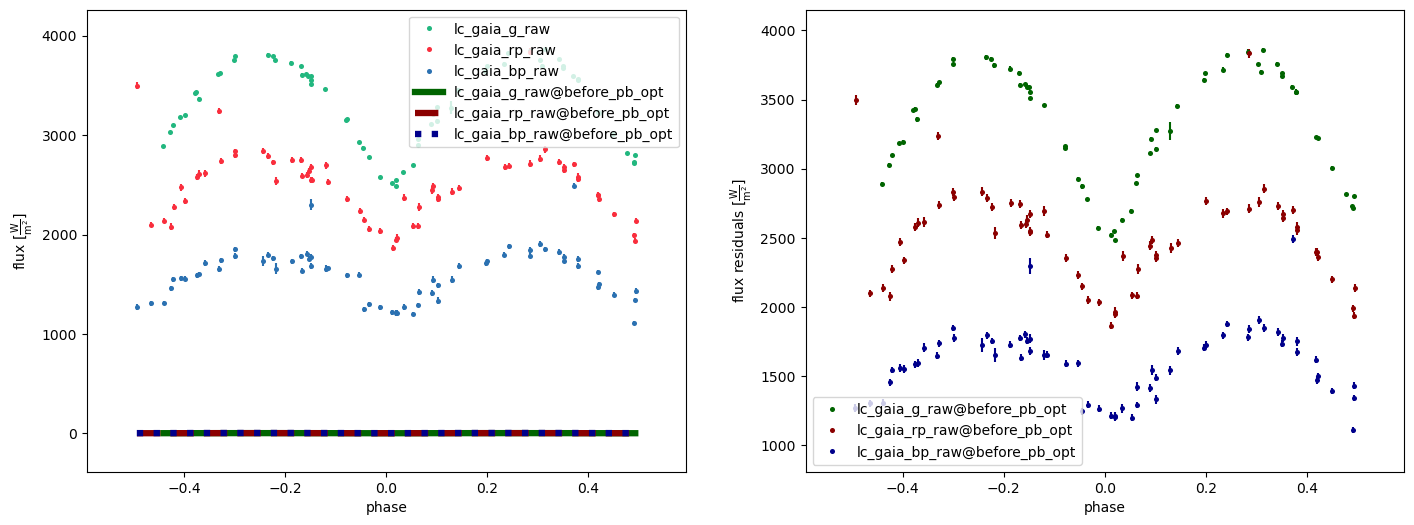

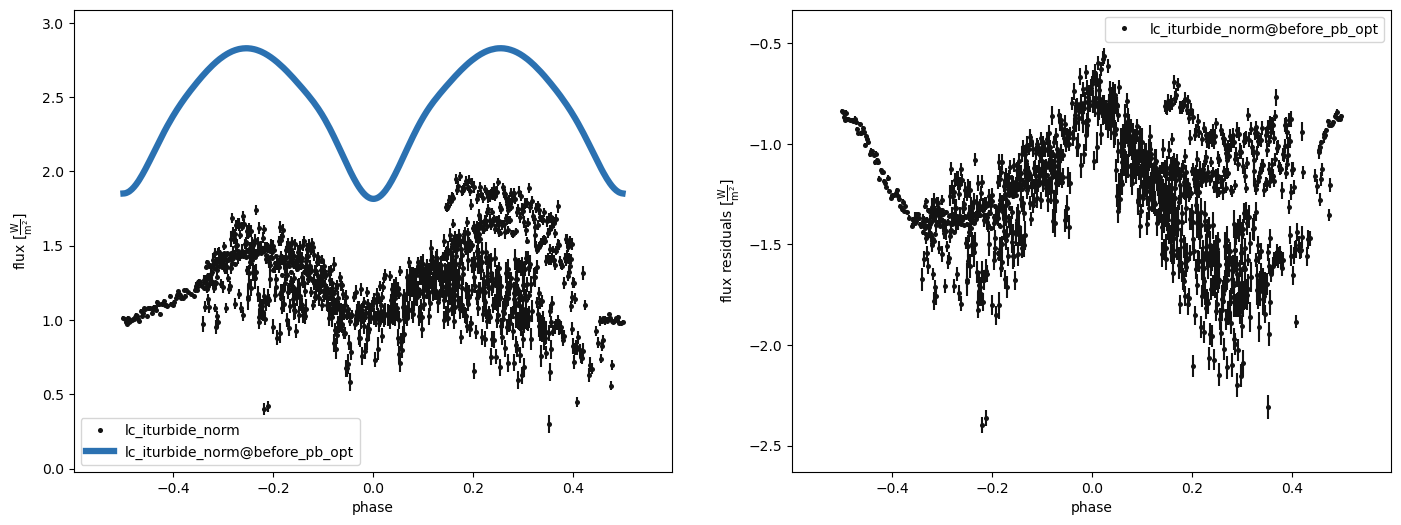

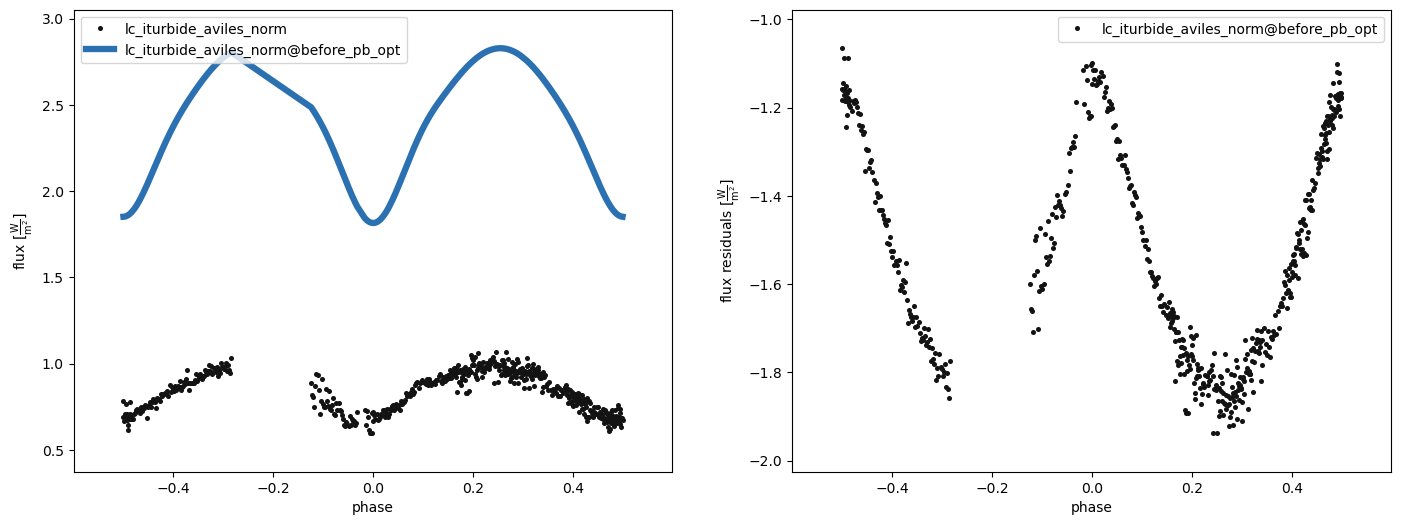

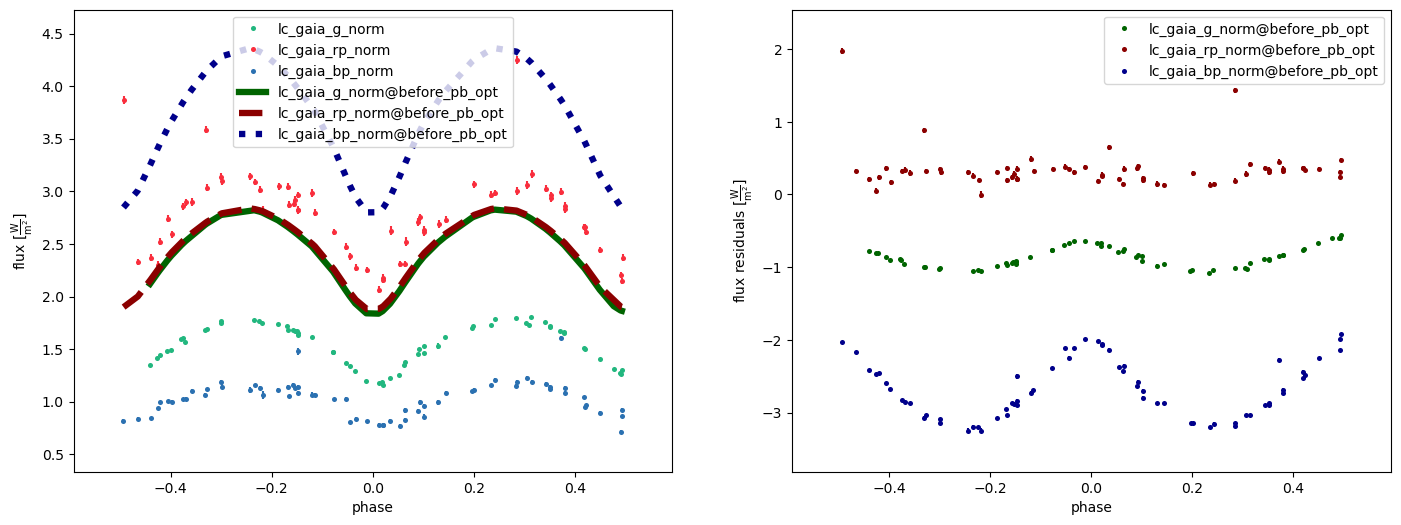

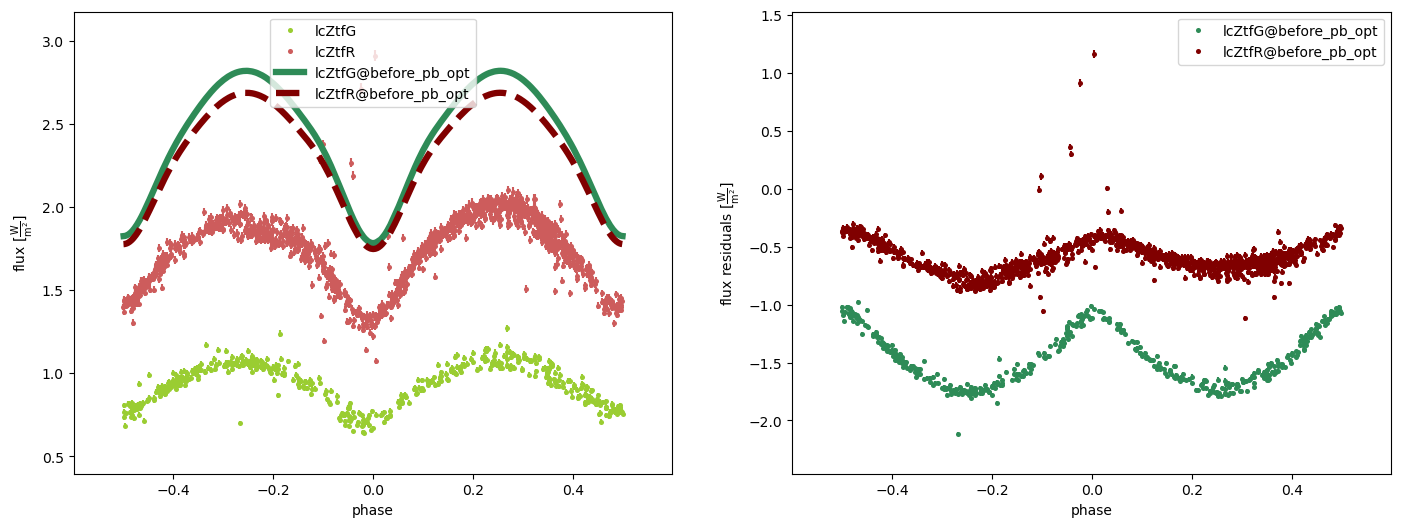

In [52]:
b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='before_pb_opt', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model='before_pb_opt')

## Original Adjustment

Coupled all Gaia LCs together; **results in bad temperature adjustment**

In [18]:
# normalized datasets; excluding Aviles norm (since it's a very sparse dataset)
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_norm", export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_norm', 'pblum@primary@lcZtfG', 'pblum@primary@lc_iturbide_norm'],
						  datasets=normGaiaDatasets + ztfDatasets + ['lc_iturbide_norm'], maxiter=500)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_norm.py


('opt_teff_ff_pblum_iturbide_gaia_ztf_norm',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution')

Adopted:
teffratio@binary@orbit@component = 0.97749 
fillout_factor@contact_envelope@envelope@component = 0.21877 
teff@primary@star@component = 4375.68352 K
pblum@primary@lc_gaia_g_norm@lc@dataset = 8.71020 W
pblum@primary@lcZtfG@lc@dataset = 5.15386 W
pblum@primary@lc_iturbide_norm@lc@dataset = 6.78961 W

Original values:
  teffratio@binary@orbit@component 0.9857284692267768
  fillout_factor@contact_envelope@envelope@component 0.1852193760747716
  teff@primary@star@component 6000.0 K
  pblum@primary@lc_gaia_g_norm@lc@dataset 12.566370614359172 W
  pblum@primary@lcZtfG@lc@dataset 12.566370614359172 W
  pblum@primary@lc_iturbide_norm@lc@dataset 12.566370614359172 W


100%|██████████| 3124/3124 [06:35<00:00,  7.90it/s]


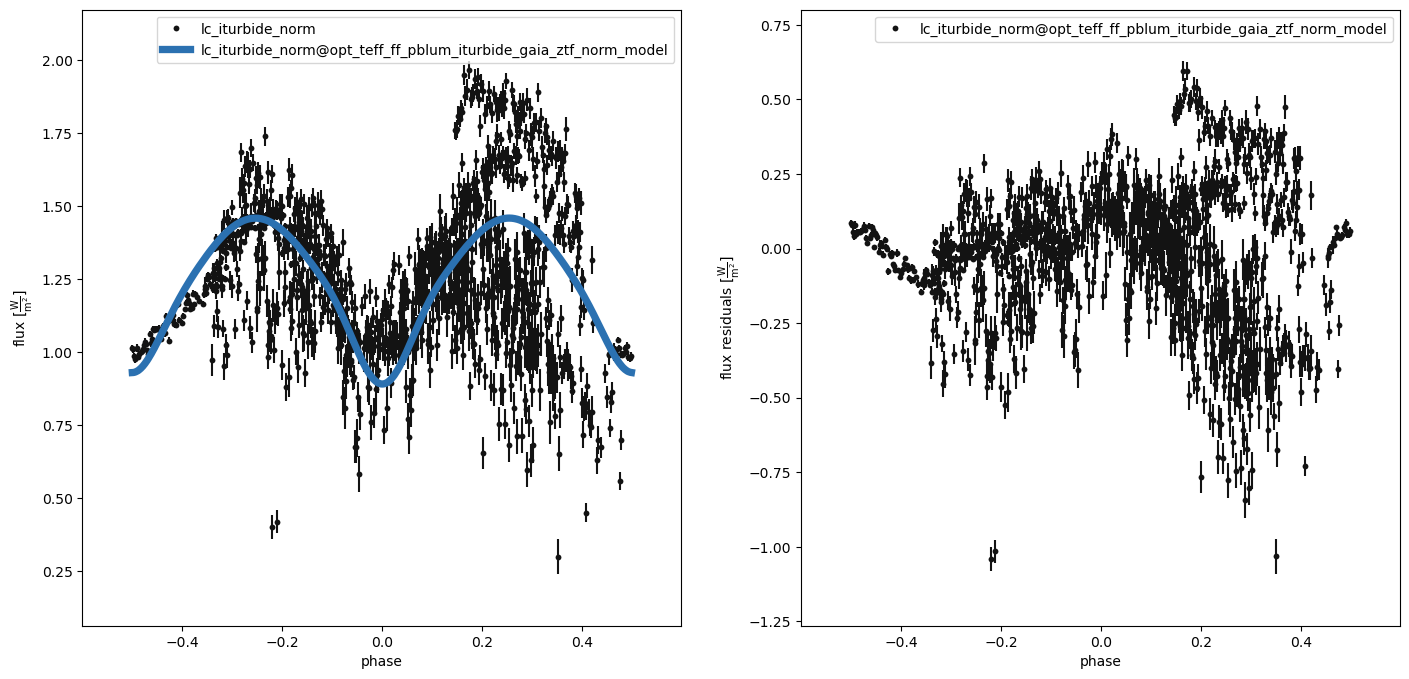

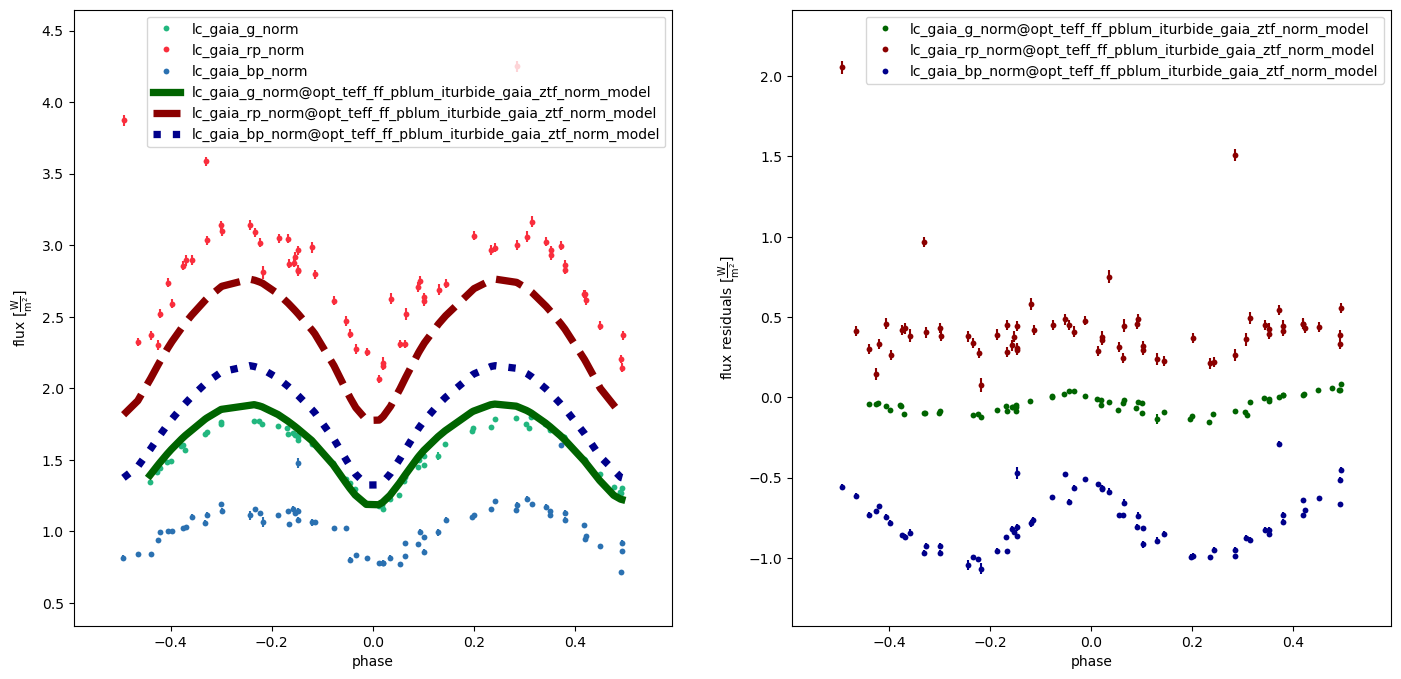

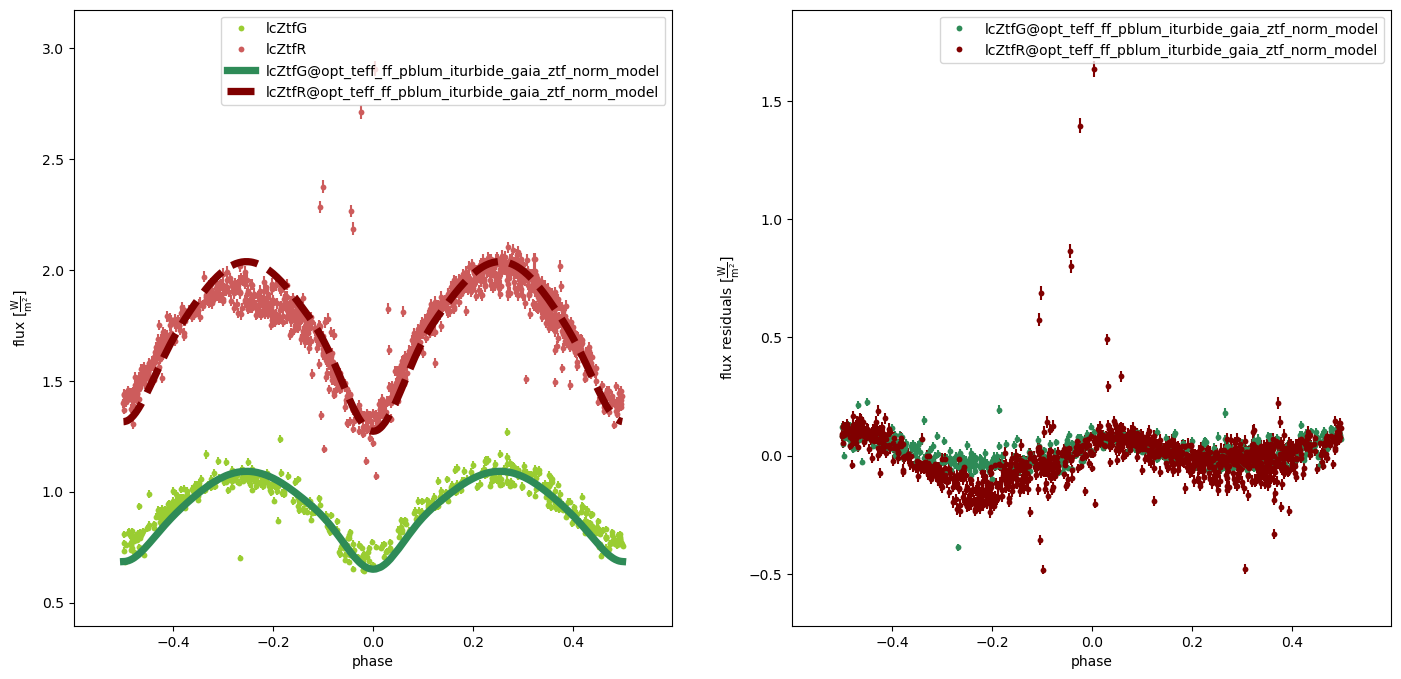

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [19]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 
													solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution", 
													reset_params=True, dataset=['mesh01', 'lc_iturbide_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.plotModelResidualsFigsize(b, figsize=(17, 8), datasetGroups=[['lc_iturbide_norm'], normGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

In [20]:
# raw datasets only
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw'],
						  datasets=rawGaiaDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_raw',
 'opt_teff_ff_pblum_iturbide_gaia_raw_solution')

In [21]:
# raw + ZTF
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw', 'pblum@primary@lcZtfG'],
						  datasets=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_ztf_raw',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution')

## Adjusting Sets of Colors

3 different optimizers to determine component $T_{eff}$: using only Gaia color ($BP - RP$), using only ZTF color ($G - R$), and one using both sets of light curves.

Only adjusting `teffratio`, `teff@primary`, and `pblum`; adjusting radii using `fillout_factor` should probably be done before changing passband scaling.

In [22]:
# gaia only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lc_gaia_rp_norm'], label='gaia_br_teff', export=True,overwrite_export=False,
						  datasets=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

# ztf only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lcZtfG'], label='ztf_teff', export=True,overwrite_export=False,
						  datasets=ztfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=250)

# gaia + ztf
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lcZtfG', 'pblum@primary@lc_gaia_rp_norm'], label='gaia_br_ztf_teff', export=True, overwrite_export=False,
						  datasets=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_br_teff.py
Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_ztf_teff.py
Solver already exists | ./external-jobs/iturbide-gaia-ztf-relative_norm/optimizer.nelder_mead_opt_gaia_br_ztf_teff.py


('opt_gaia_br_ztf_teff', 'opt_gaia_br_ztf_teff_solution')

Adopted:
Not adopting teffratio@binary@orbit@component
Not adopting teff@primary@star@component
Not adopting pblum@primary@lcZtfG@lc@dataset
Not adopting pblum@primary@lc_gaia_rp_norm@lc@dataset

Original values:
Not adopting teffratio@binary@orbit@component
Not adopting teff@primary@star@component
Not adopting pblum@primary@lcZtfG@lc@dataset
Not adopting pblum@primary@lc_gaia_rp_norm@lc@dataset


100%|██████████| 1864/1864 [04:13<00:00,  7.34it/s]


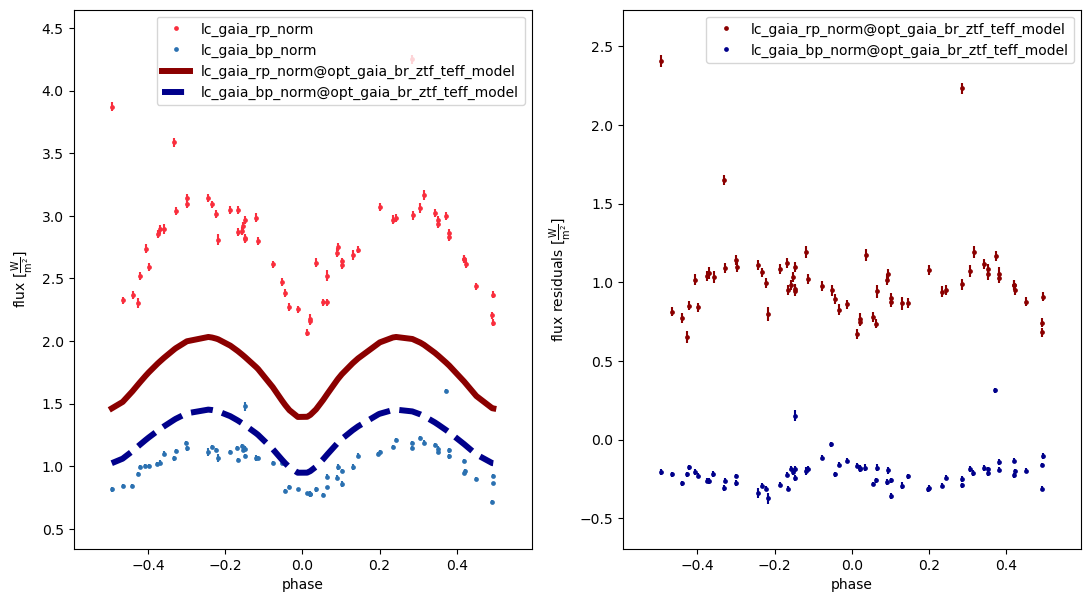

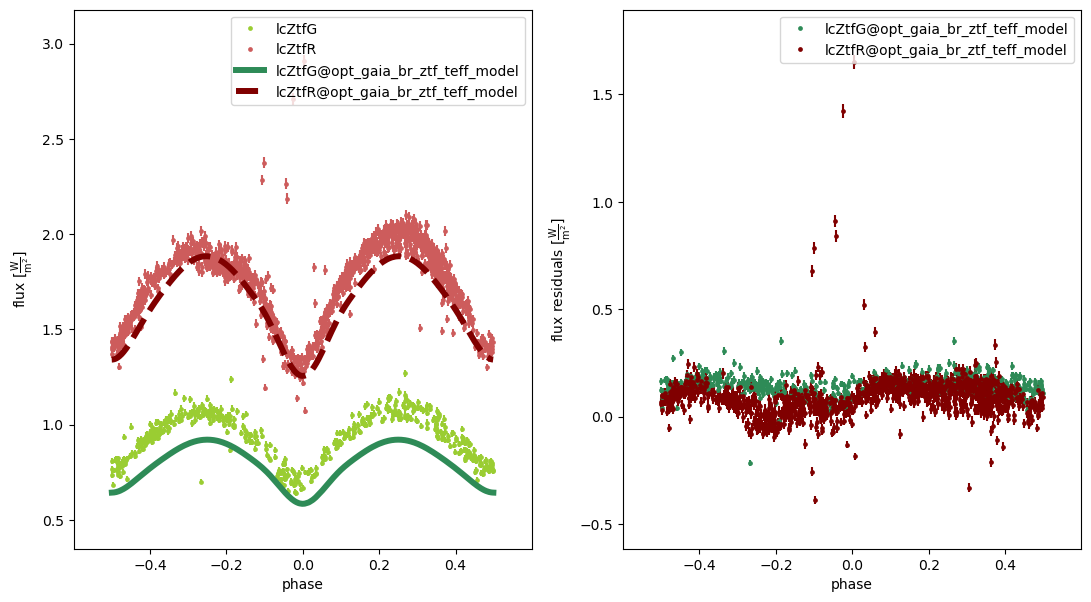

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [65]:
# gaia + ztf
gen_utils.abilitateDatasets(b, ['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_gaia_br_ztf_teff_solution", reset_params=True, 
														  adopt_twigs=['teff@primary', 'pblum@primary@lc_gaia_rp_norm', 'pblum@primary@lcZtfG'])
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

In [66]:
# gaia only
try:
	gen_utils.abilitateDatasets(b, ['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets)
	solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_gaia_br_teff_solution", 
															adopt_twigs=['teff@primary', 'pblum@primary@lc_gaia_rp_norm'], reset_params=True)
	gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], ztfDatasets], model=computeModelName)
	gen_utils.animateMesh(b, logger, model=computeModelName)
except ValueError as e:
	print("Failed to adopt solution", e)

Adopted:
Not adopting teffratio@binary@orbit@component
Not adopting teff@primary@star@component
Not adopting pblum@primary@lc_gaia_rp_norm@lc@dataset

Original values:
Not adopting teffratio@binary@orbit@component
Not adopting teff@primary@star@component
Not adopting pblum@primary@lc_gaia_rp_norm@lc@dataset


Sat, 06 Jan 2024 13:33 UNIVERSE     WARNING Atmosphere parameters out of bounds: Teff=[3493.91811977 3457.18097424 3442.73111862 3473.10563771 3422.60593847
 3481.1493306  3441.47127153 3476.71314377 3488.65889167 3380.54001942
 3418.24965643 3337.91148131 3337.54806456 3387.6639254  3411.52784107
 3443.13189563 3444.81626181 3486.75881037 3471.20418317 3396.98125948
 3334.42672953 3304.87495437 3275.06282932 3301.49118342 3254.70843941
 3346.75728996 3257.49447793 3472.12286372 3399.2843302  3297.12748425
 3492.39898782 3425.40884006 3487.43232443 3439.06853336 3456.9843266
 3355.9491687  3462.20962995 3470.07422782 3478.43949733 3493.94583897
 3406.32545301 3449.11783493 3489.13038902 3478.60391387 3440.96864378
 3398.47959815 3340.71174499 3291.73160177 3270.65599422 3426.01786841
 3402.77459415 3407.93786947 3369.71801142 3331.86488087 3283.17012562
 3333.52904836 3284.6049461  3320.22261941 3303.53307111 3261.89072727
 3261.88370219 3261.88370219 3261.88370219 3261.78045751 3261.7

Failed to adopt solution Could not compute ldint with ldatm='ck2004'.  Try changing atm to a table that covers a sufficient range of values.  If necessary, set atm to 'blackbody' and/or ld_mode to 'manual' (in which case coefficients will need to be explicitly provided via ld_coeffs). Enable 'warning' logger to see out-of-bound arrays.


Adopted:
Not adopting teffratio@binary@orbit@component
teff@primary@star@component = 4396.90116 K
pblum@primary@lcZtfG@lc@dataset = 5.03536 W

Original values:
Not adopting teffratio@binary@orbit@component
  teff@primary@star@component 6000.0 K
  pblum@primary@lcZtfG@lc@dataset 12.566370614359172 W


100%|██████████| 1864/1864 [04:21<00:00,  7.12it/s]


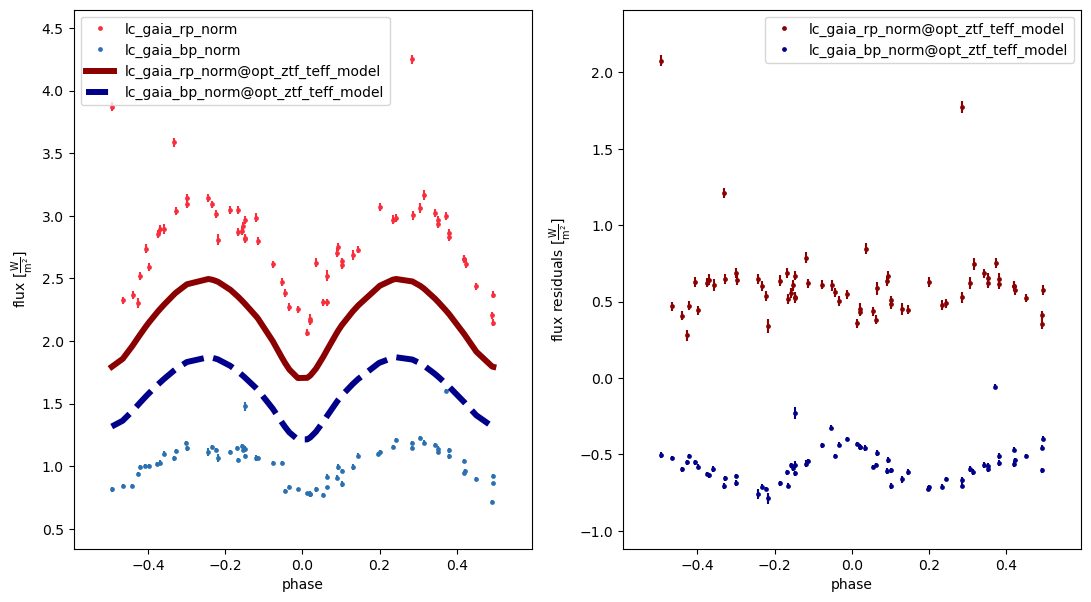

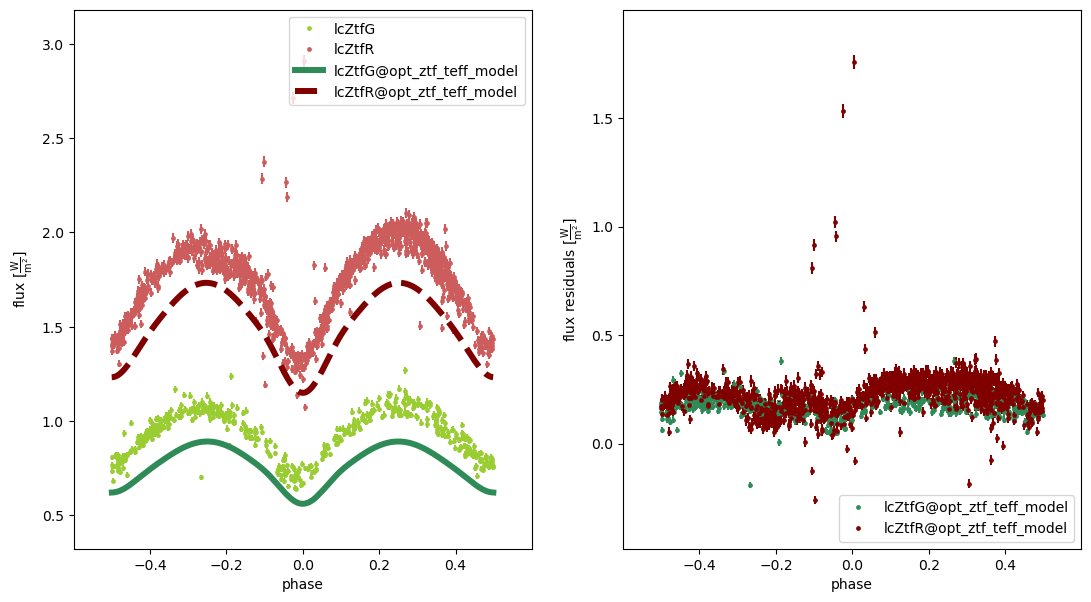

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [67]:
# ztf only
gen_utils.abilitateDatasets(b, ['lc_gaia_rp_norm', 'lc_gaia_bp_norm'] + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_ztf_teff_solution", 
														  adopt_twigs=['teff@primary@star@component', 'pblum@primary@lcZtfG@lc@dataset'], reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

In [68]:
# adopting ZTF only optimization run
b.adopt_solution(solution='opt_ztf_teff_solution')

<ParameterSet: 4 parameters | contexts: dataset, component>

# `pblum` Optimization

In [69]:
print(b['pblum'])

ParameterSet: 9 parameters
   pblum@primary@lc_iturbide_n...: 12.566370614359172 W
   pblum@primary@lc_iturbide_r...: 12.566370614359172 W
   pblum@primary@lc_iturbide_a...: 12.566370614359172 W
   pblum@primary@lc_iturbide_a...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_nor...: 12.566370614359172 W
   pblum@primary@lc_gaia_rp_no...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W
   pblum@primary@lc_gaia_rp_ra...: 12.566370614359172 W
     pblum@primary@lcZtfG@dataset: 5.035357561921641 W


## ZTF

 80%|████████  | 16/20 [1:57:11<29:17, 439.46s/it]  


Adopted:
pblum@primary@lcZtfG@lc@dataset = 5.84683 W

Original values:
  pblum@primary@lcZtfG@lc@dataset 4.909166289038033 W


100%|██████████| 3673/3673 [08:03<00:00,  7.60it/s]


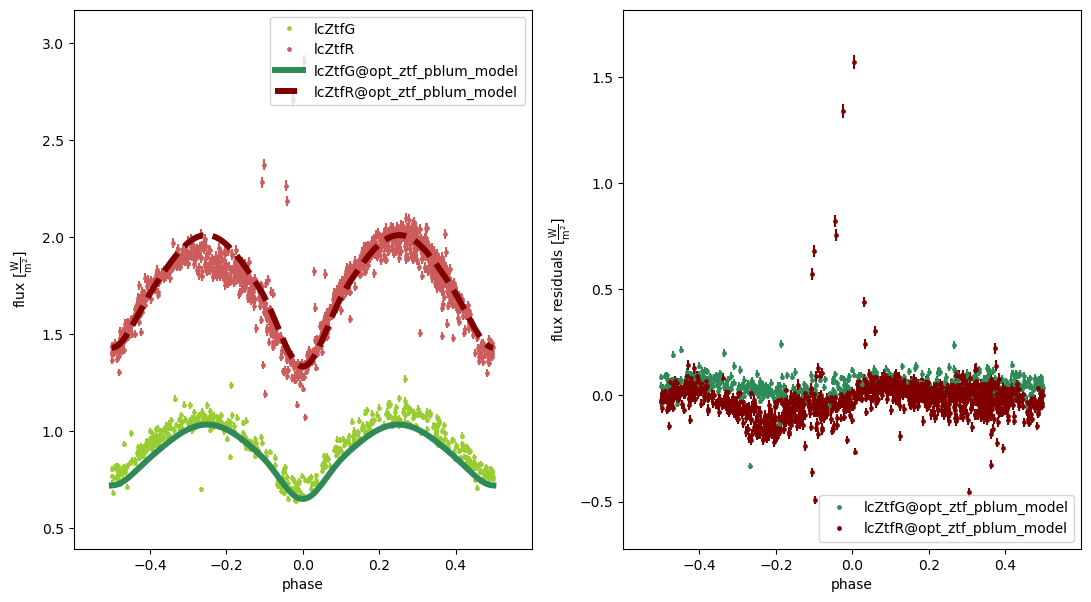

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [80]:
# final adjustment of ZTF pblum; need to adjust due to new teffratio used
solutionPath = gen_solution_path('ztf_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lcZtfG@dataset'], label='ztf_pblum', export=False, datasets=ztfDatasets, maxiter=20)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

## Iturbide

 50%|█████     | 20/40 [1:43:11<1:43:11, 309.56s/it]


Adopted:
pblum@primary@lc_iturbide_norm@lc@dataset = 7.79347 W

Original values:
  pblum@primary@lc_iturbide_norm@lc@dataset 12.566370614359172 W


100%|██████████| 3673/3673 [08:09<00:00,  7.50it/s]


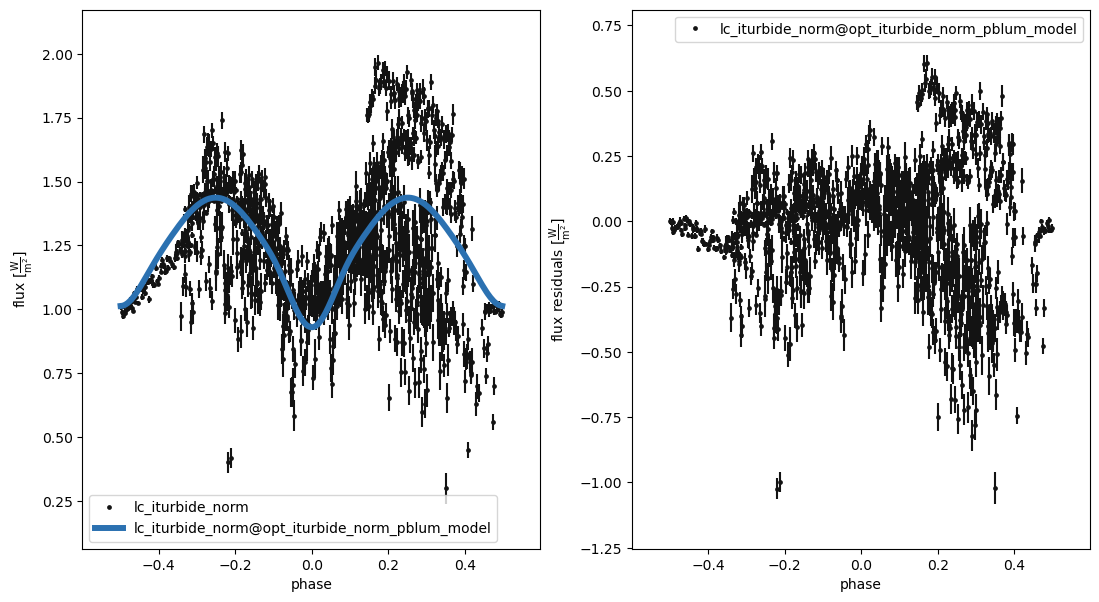

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [81]:
# norm full
solutionPath = gen_solution_path('iturbide_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_norm@dataset'], label='iturbide_norm_pblum', export=False, datasets=['lc_iturbide_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_norm'], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

 50%|█████     | 20/40 [47:15<47:15, 141.76s/it]  


Adopted:
pblum@primary@lc_iturbide_aviles_norm@lc@dataset = 5.34117 W

Original values:
  pblum@primary@lc_iturbide_aviles_norm@lc@dataset 12.566370614359172 W


100%|██████████| 3673/3673 [08:05<00:00,  7.56it/s]


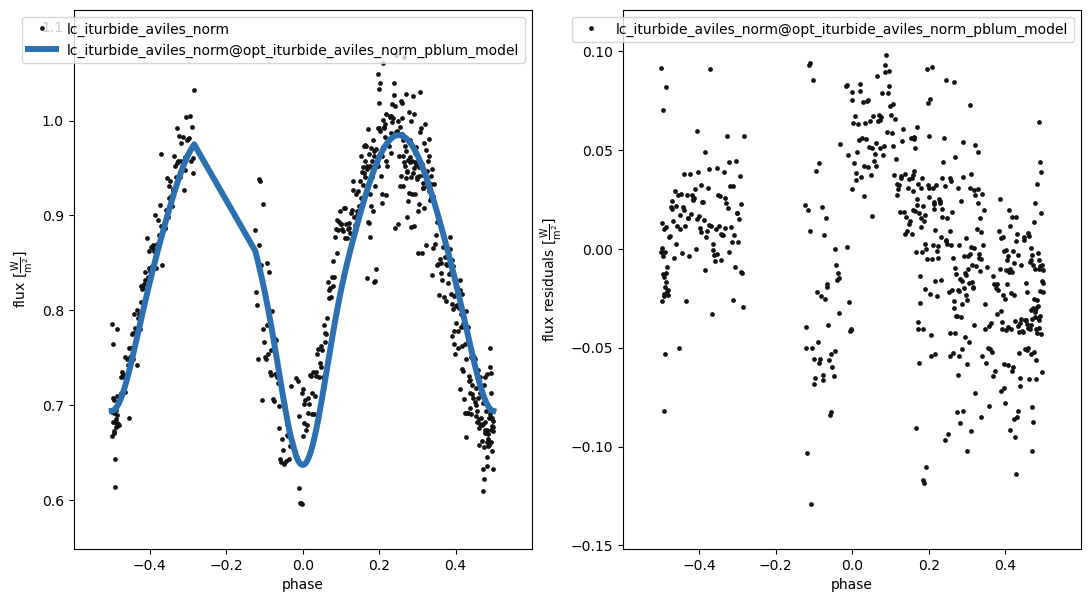

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [82]:
# norm Aviles
solutionPath = gen_solution_path('iturbide_aviles_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_aviles_norm@dataset'], label='iturbide_aviles_norm_pblum', export=False, 
											 	datasets=['lc_iturbide_aviles_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_aviles_norm'], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

## Gaia

In [85]:
beforeGaiaPb = b.copy()

### Normalized data

100%|██████████| 213/213 [00:32<00:00,  6.65it/s]


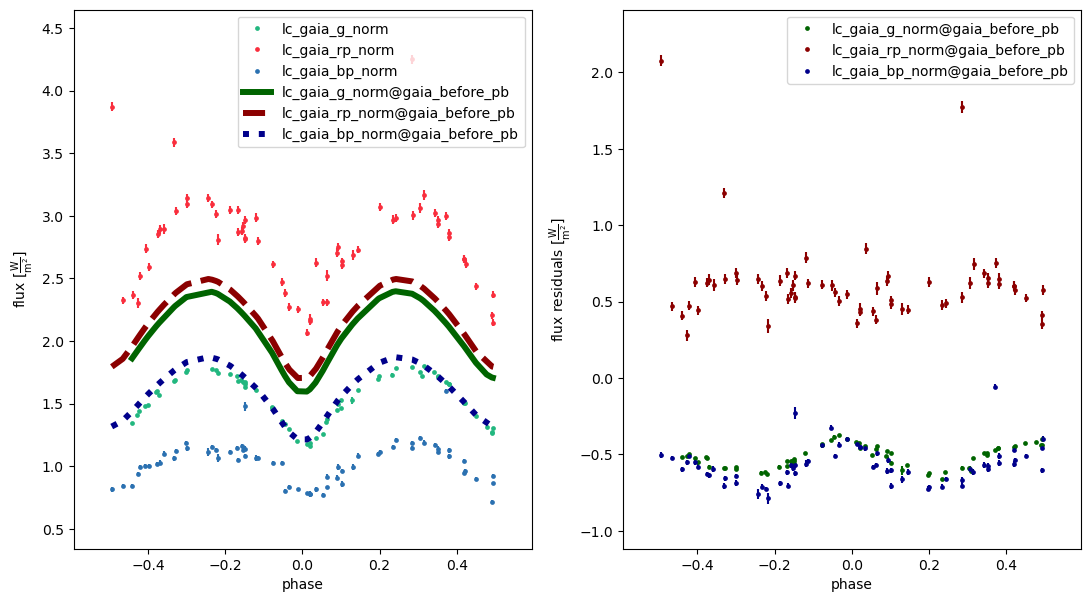

In [83]:
gen_utils.abilitateDatasets(b, normGaiaDatasets)
b.run_compute(model='gaia_before_pb', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[normGaiaDatasets], model='gaia_before_pb')

In [86]:
# coupling Gaia datasets to see how data looks
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_g_norm'], value='component-coupled')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_norm', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_norm', value='lc_gaia_g_norm')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_rp_norm', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_rp_norm', value='lc_gaia_g_norm')

100%|██████████| 213/213 [00:32<00:00,  6.63it/s]


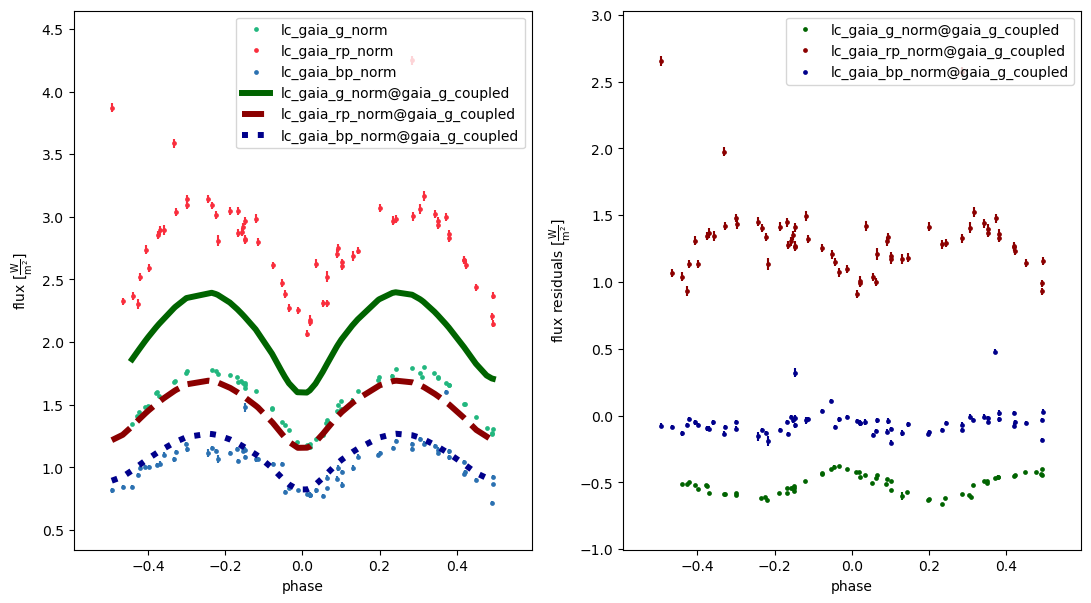

In [87]:
gen_utils.abilitateDatasets(b, normGaiaDatasets)
b.run_compute(model='gaia_g_coupled', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[normGaiaDatasets], model='gaia_g_coupled')

### Raw data

In [88]:
# coupling Gaia datasets to see how data looks
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_g_raw'], value='component-coupled')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_bp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_bp_raw', value='lc_gaia_g_raw')

b.set_value(qualifier='pblum_mode', dataset='lc_gaia_rp_raw', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lc_gaia_rp_raw', value='lc_gaia_g_raw')

100%|██████████| 213/213 [00:29<00:00,  7.11it/s]


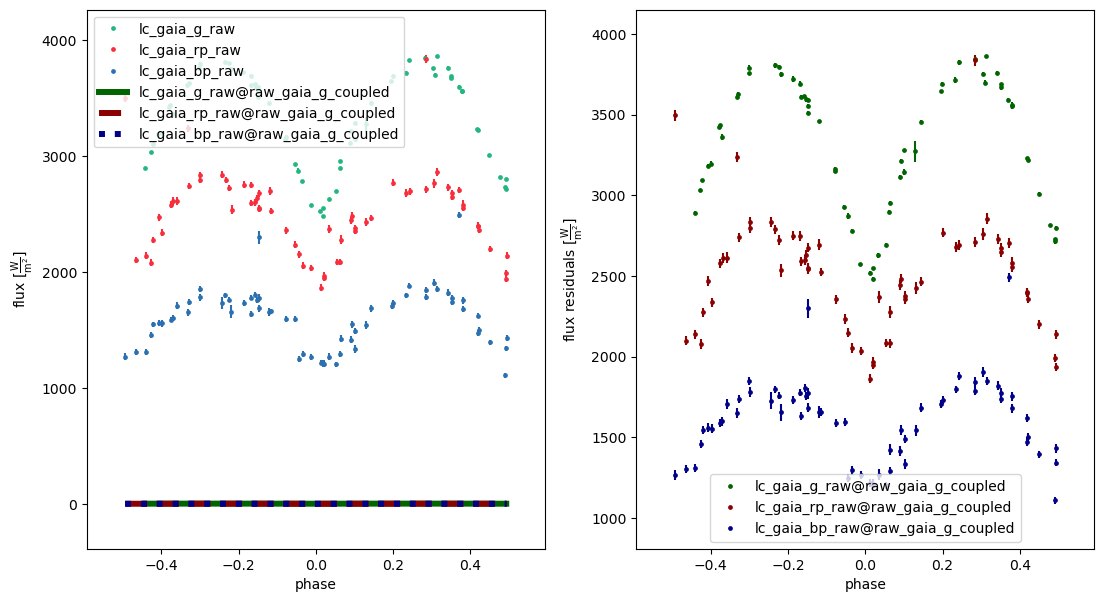

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [89]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
b.run_compute(model='raw_gaia_g_coupled', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets], model='raw_gaia_g_coupled')

100%|██████████| 40/40 [14:46<00:00, 22.16s/it]


Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset = 20266.27584 W

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 213/213 [00:30<00:00,  7.10it/s]


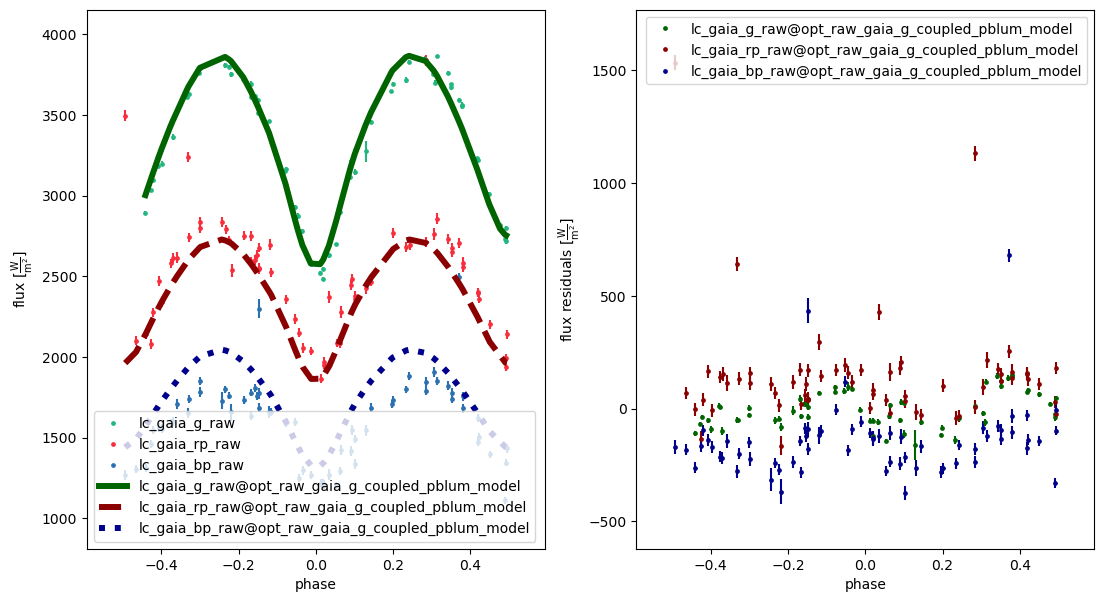

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [90]:
# optimize passband luminosity
solutionPath = gen_solution_path('raw_gaia_g_coupled_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw@dataset'], label='raw_gaia_g_coupled_pblum', export=False, 
											 	datasets=['lc_gaia_g_raw'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

gen_utils.abilitateDatasets(b, rawGaiaDatasets)
_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets], model=computeModelName)